In [1]:
import sys
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource, LogNorm
import numpy as np
import sys 
import os
import h5py
from torreylabtools import helpers
from astropy import constants as cons
from astropy import units as u
import matplotlib as mpl
from LtU_get_property_notebook import get_particle_property_LTU
import arepo_package_notebook as arepo_package

%matplotlib inline

In [2]:
os.environ["MANPATH"] = "/standard/torrey-group/Share/texlive/2018/texmf-dist/doc/man:" + os.environ.get("MANPATH", "")
os.environ["INFOPATH"] = "/standard/torrey-group/Share/texlive/2018/texmf-dist/doc/info:" + os.environ.get("INFOPATH", "")
os.environ["PATH"] = "/standard/torrey-group/Share/texlive/2018/bin/x86_64-linux:/standard/torrey-group/Share/texlive/2018/texmf-dist:" + os.environ.get("PATH", "")

In [3]:
# Observed JWST BHs; redshift, mass

UHZ1 = [10.1,4e7] # https://iopscience.iop.org/article/10.3847/2041-8213/ad0e76/pdf
GHZ9 = [10.145,1.6e8] # https://arxiv.org/abs/2410.18763
CEERS1019 = [8.679,10**6.95] # https://arxiv.org/abs/2303.08918
GNZ11 = [10.6,10**6.2] # https://www.nature.com/articles/s41586-024-07052-5

# Gas masses/densities within BH kernel and radius d

In [4]:
d = 0.140 # Zoom radius # 0.375 # Constrained radius

Filepath = '/project/torrey-group/jkho/LtU_accretion' 
Box = 'Zooms' # 'Constrained' # 'Low_mass_seeds' # 
# SimPaths = [['Bondi_lowmass_AGN_fewseeds_z127','Bondi_lowmass_noAGN_fewseeds_z127','Bondi_lowmass_AGN_fewseeds_lowstellar_z127','Bondi_lowmass_noAGN_fewseeds_nostellar_z127'],
#             ['FF_lowmass_AGN_fewseeds_z127','FF_lowmass_noAGN_fewseeds_z127','FF_lowmass_AGN_fewseeds_lowstellar_z127','FF_lowmass_noAGN_fewseeds_nostellar_z127'], # Last sim IS no stellar, needs to be low stellar
#             ['modFF_lowmass_AGN_fewseeds_z127','modFF_lowmass_noAGN_fewseeds_z127','modFF_lowmass_AGN_fewseeds_lowstellar_z127','modFF_lowmass_noAGN_fewseeds_nostellar_z127']]
SimPaths = [['Bondi_zoom_AGN','Bondi_zoom_boost_noAGN_stellar','Bondi_zoom_AGN_0.1stellar','Bondi_zoom_noAGN_0.1stellar'],
            ['FF_zoom_AGN','FF_zoom_noAGN_stellar','FF_zoom_AGN_0.1stellar','FF_zoom_noAGN_0.1stellar'],
            ['modFF_zoom_AGN','modFF_zoom_noAGN_stellar','modFF_zoom_AGN_0.1stellar','modFF_zoom_noAGN_0.1stellar']]
# SimPaths = [['Bondi_constrained_AGN_fewseeds_stellar','Bondi_constrained_noAGN_fewseeds_boost','Bondi_constrained_AGN_fewseeds_0.1stellar', 'Bondi_constrained_noAGN_0.1stellar',],
#             ['FF_constrained_AGN_fewseeds_stellar','FF_constrained_noAGN_fewseeds','FF_constrained_AGN_fewseeds_0.1stellar','FF_constrained_noAGN_0.1stellar'],
#             ['modFF_constrained_AGN_fewseeds_stellar','modFF_constrained_noAGN_fewseeds','modFF_constrained_AGN_fewseeds_0.1stellar','modFF_constrained_noAGN_0.1stellar']] 
# [['Bondi_lowmass_noAGN_fewseeds_z127','FF_lowmass_noAGN_fewseeds_z127','modFF_lowmass_noAGN_fewseeds_z127'],['Bondi_lowmass_AGN_fewseeds_z127','FF_lowmass_AGN_fewseeds_z127','modFF_lowmass_AGN_fewseeds_z127']] #[['Bondi_zoom_boost','FF_zoom','modFF_zoom'],['Bondi_zoom_AGN','FF_zoom_AGN','modFF_zoom_AGN']]# ['Bondi_constrained_noAGN_fewseeds','FF_constrained_noAGN_fewseeds','modFF_constrained_noAGN_fewseeds'] #  
outputpath = 'output'  # 'Bondi_seed3.19_nofeedback_fewseeds'

redshifts = np.arange(6,17) # np.linspace(12,5,8)
a = 1/(1+redshifts)

sim = SimPaths[0][2]
basePath = f'{Filepath}/{Box}/{sim}/{outputpath}/'
        
header = arepo_package.load_snapshot_header(basePath,8)
boxsize = header['BoxSize']
# boxsize = 3125.0 
h = 0.6774

gas_masses = []
gas_temp = []
gas_coords = []
BH_coords = []

for i in range(len(redshifts)):
    
    BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[i])[0] * 1e10/h
    BH_Hsml = get_particle_property_LTU(basePath,'BH_Hsml',p_type=5, desired_redshift = redshifts[i])[0] * a[i]/h
    BH_pos = get_particle_property_LTU(basePath,'Coordinates',p_type=5, desired_redshift = redshifts[i])[0] * a[i]/h
    Gas_pos = get_particle_property_LTU(basePath,'Coordinates',p_type=0, desired_redshift = redshifts[i])[0] * a[i]/h
    Gas_Mass = get_particle_property_LTU(basePath,'Masses',p_type=0, desired_redshift = redshifts[i])[0] * 1e10/h
    U = get_particle_property_LTU(basePath,'InternalEnergy',p_type=0, desired_redshift = redshifts[i])[0] # (km/s)^2
    x_e = get_particle_property_LTU(basePath,'ElectronAbundance',p_type=0, desired_redshift = redshifts[i])[0]

    # if np.isnan(BH_Mass[0]):
        
    #     gas_masses.append(np.nan)
    #     gas_temp.append(np.nan)
    #     gas_coords.append(np.nan)
    #     BH_coords.append(np.nan)
    #     continue
    
    most_massive_BH = np.argmax(BH_Mass)

    hsml = BH_Hsml[most_massive_BH]
    MMBH_coord = BH_pos[most_massive_BH]

    gas_in_hsml = np.linalg.norm(Gas_pos - MMBH_coord,axis=1) < hsml

    gas_mass_in_hsml = Gas_Mass[gas_in_hsml]
    gas_pos_in_hsml = Gas_pos[gas_in_hsml]
    gas_u_in_hsml = U[gas_in_hsml] * u.km**2/u.s**2
    gas_xe_in_hsml = x_e[gas_in_hsml]

    # See https://www.tng-project.org/data/docs/faq/#gen6
    XH = 0.76
    gamma = 5/3
    mu = 4/(1 + 3*XH + 4*XH*gas_xe_in_hsml) * cons.m_p
    T = (gamma - 1)*gas_u_in_hsml/cons.k_B * mu
    T = T.to(u.K).value
    
    gas_masses.append(gas_mass_in_hsml)
    gas_temp.append(T)
    gas_coords.append(gas_pos_in_hsml)
    BH_coords.append(MMBH_coord)

# gas_masses = np.array(gas_masses)

Desired redshift:  8
Output redshift:  8.012172948865935
Output snapshot:  17


KeyboardInterrupt: 

Want to calculate average temperatures for Constrained, Zoom, and Small Uniform boxes, compare number of outliers with high temp as well

In [117]:
z = 8
n = 5
top_idx = np.argsort(gas_temp[z])[-n:]
all_except_top = np.setdiff1d(np.arange(len(gas_temp[z])), top_idx)
print(np.log10(gas_masses[z][top_idx]))
print(np.log10(gas_temp[z][top_idx]))

[4.663883  4.4585824 4.5324545 4.4714584 4.4826593]
[5.01346507 5.01428215 5.01444077 5.01575576 5.02093443]


In [118]:
print(f"With top {n}:",np.mean(gas_temp[z]),np.median(gas_temp[z]))
print(f"Without top {n}:",np.mean(gas_temp[z][all_except_top]),np.median(gas_temp[z][all_except_top]))

With top 5: 97372.94614852595 97991.09870269251
Without top 5: 97053.3354780827 97798.66898159613


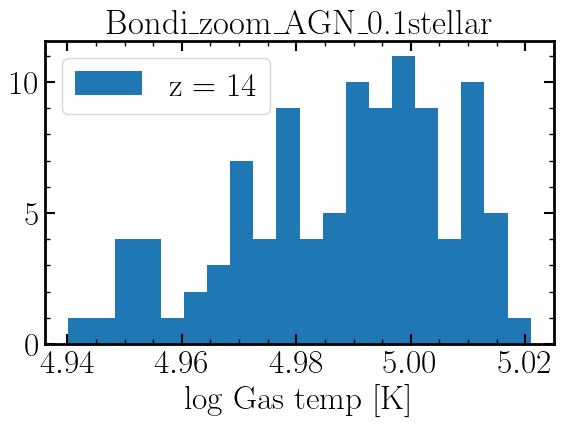

In [119]:
plt.hist(np.log10(gas_temp[z]),bins=20,label = f'z = {redshifts[z]}')
# plt.xscale('log')
plt.xlabel('log Gas temp [K]')
plt.title(f'{sim}',size=25)
plt.legend()
plt.tight_layout()
plt.savefig(f'Plots/{Box}/{sim}_temp_z{redshifts[z]}.png')

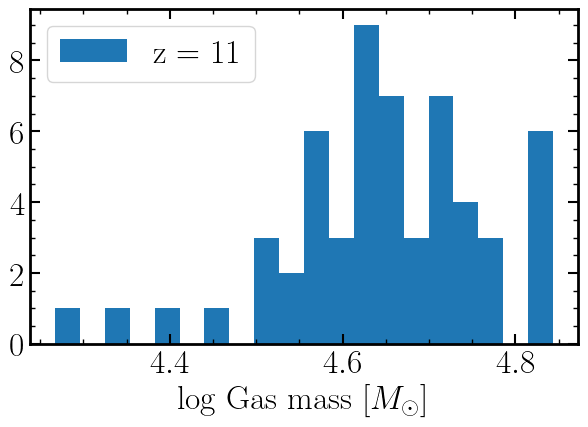

In [25]:
plt.hist(np.log10(gas_masses[z]),bins=20,label = f'z = {redshifts[z]}')
# plt.vlines(np.log10(gas_masses[z][top_idx]),0,20,color='orange')
plt.xlabel(r'log Gas mass [$M_\odot$]')
plt.legend()
plt.tight_layout()
plt.savefig(f'Plots/{Box}/{sim}_mass_z{redshifts[z]}.png')

Maybe try plotting the distribution of the gas cells to see where the hot cells are?

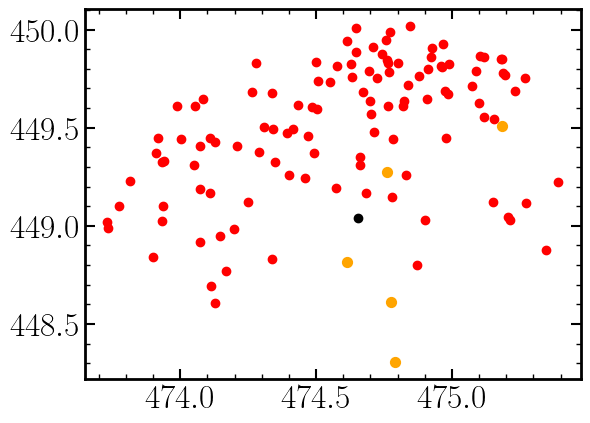

In [79]:
plt.scatter(BH_coords[z][0],BH_coords[z][1],color='k')
plt.scatter(gas_coords[z][:,0],gas_coords[z][:,1],color='red')
plt.scatter(gas_coords[z][:,0][top_idx],gas_coords[z][:,1][top_idx],color='orange',s=50)

# BHMF

In [4]:
BHMFs = []
all_bin_centers = []

log_mass_bins = np.arange(3, 9, 0.25)  # from 1e5 to 1e10.5 Msun
mass_bins = 10**log_mass_bins

for i in range(len(redshifts)):

    bh_masses = AllBHmasses[i]
    
    # Histogram BH masses
    counts, bin_edges = np.histogram(bh_masses, bins=mass_bins)
    
    # Compute bin centers
    bin_centers = 10**((np.log10(bin_edges[:-1]) + np.log10(bin_edges[1:])) / 2)
    
    # --- CALCULATE VOLUME AND BHMF ---
    
    # Comoving volume in Mpc^3
    volume = (boxsize / h)**3  # Mpc^3
    
    # Width of each bin in log10 space
    dlogM = np.log10(bin_edges[1:]) - np.log10(bin_edges[:-1])
    
    # BH mass function: number density per dex
    bhmf = counts / (volume * dlogM)  # units: Mpc^-3 dex^-1

    BHMFs.append(bhmf)
    all_bin_centers.append(bin_centers)


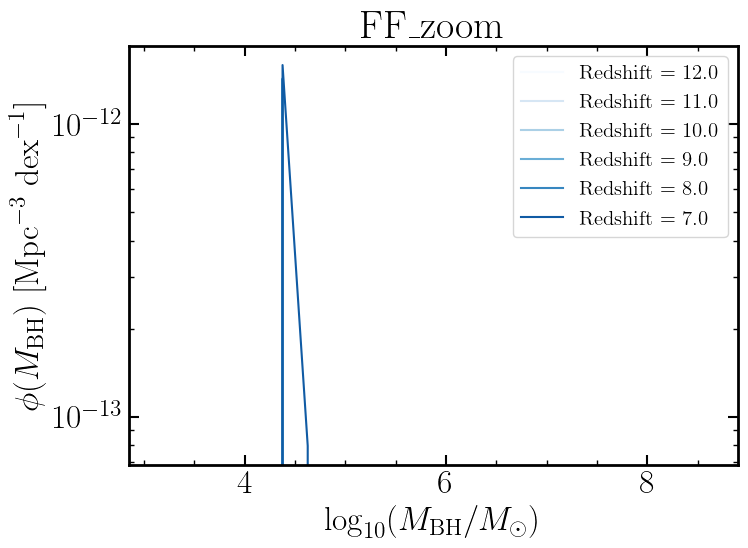

In [5]:
cmap = mpl.colormaps['Blues']

Rainer_FF_Mf = np.array([1317.219403895693, 0.2330442473103899,1877.172889866675, 0.1485148830563913,3131.3131060039846, 0.05526218014860035,5223.345074266833, 0.03215591027918435,8053.467417820163, 0.01497401094429634,12915.496650148827, 0.011919532759938074,19913.394573407288, 0.004641588833612777,31935.48412908937, 0.003863716279408309,49238.826317067316, 0.0023528130488540576,148231.38652959914, 0.001361227750251082,502174.55206527887, 0.0007522441315764914])
Rainer_FF_Mf_x = np.log10(Rainer_FF_Mf[list(np.arange(0,len(Rainer_FF_Mf)-2,2))])
Rainer_FF_Mf_y = Rainer_FF_Mf[list(np.arange(1,len(Rainer_FF_Mf)-1,2))]

plt.figure(figsize=(8, 6))

for i in range(len(redshifts)):
    plt.plot(np.log10(all_bin_centers[i]), BHMFs[i],label = f'Redshift = {redshifts[i]}',color = cmap(i/len(redshifts)))

# plt.plot(Rainer_FF_Mf_x,Rainer_FF_Mf_y,label = 'Rainer z=5',color='green')
plt.xlabel(r'$\log_{10}(M_{\rm BH} / M_\odot)$')
plt.ylabel(r'$\phi(M_{\rm BH})\ [\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1}]$')
plt.title(f'{Simpath}')
plt.yscale('log')
# plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(fontsize=15)
# plt.savefig(f'{Filepath}/{Simpath}/Plots/{Simpath}_BHMF.png')
plt.savefig(f'Plots/{Simpath}_BHMF.png')


# BH growth:

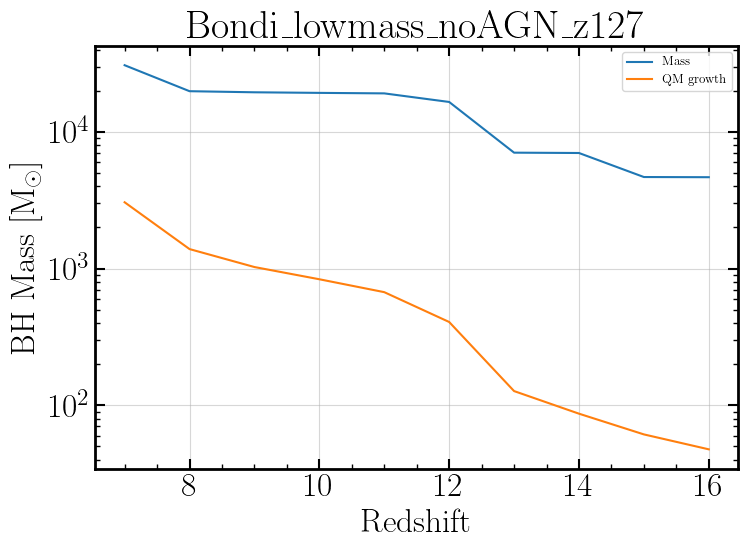

In [12]:
seed_mass = 1.25e-6 *1e10/h # 1.5625e-07 #  1e-05  # 8.0e-8*1e10/h # 
merger_driven_growth = seed_mass*(np.array(Progs) - 1)

plt.figure(figsize=(8,6))
plt.plot(redshifts,Masses,label = 'Mass')
# plt.plot(redshifts,np.array(Masses)-(np.array(QM_growth)+np.array(RM_growth)+seed_mass),label='Growth via mergers',lw=3,alpha=0.75, ls='--')
# plt.plot(redshifts,merger_driven_growth,label='Growth via mergers',ls='--')
plt.plot(redshifts,QM_growth,label='QM growth')
# plt.plot(redshifts,RM_growth,label='RM growth')

# plt.scatter(UHZ1[0],UHZ1[1],label = 'UHZ1',color='purple',marker = 'o')
# plt.scatter(GHZ9[0],GHZ9[1],label = 'GHZ9',color='purple',marker = 's')
# plt.scatter(CEERS1019[0],CEERS1019[1],label = 'CEERS-1019',color='purple',marker = '*')
# plt.scatter(GNZ11[0],GNZ11[1],label = 'GNZ11',color='purple',marker = 'v')

plt.legend(fontsize=9)
plt.yscale('log')
plt.ylabel(r'BH Mass [$\rm M_\odot$]')
plt.xlabel('Redshift')
plt.title(f'{Simpath}')
plt.grid(alpha=0.5)
# plt.ylim(1e-1,1e9)

plt.tight_layout()
# plt.savefig(f'{Filepath}/{Simpath}/Plots/{Simpath}_BH_growth.png')
plt.savefig(f'Plots/{Simpath}_BH_growth.png')

# Bolometric luminosities

$$\rm L_{bol} = \epsilon_r \dot{M}c^2 min(1,10\frac{\dot{M}}{\dot{M}_{Edd}}) $$

In [9]:
epsilon = 0.2 # radiative efficiency
light_speed = c.c

Lbol = [epsilon * AllMdots_Rainer[i] * u.Msun/u.Gyr * light_speed**2 * np.array([np.min([10*AllMdots_Rainer[i][ii]/AllEddington_Rainer[i][ii],1]) for ii in range(len(AllMdots_Rainer[i]))]) for i in range(len(redshifts))]
Lbol = [Lbol[i].to(u.erg/u.s).value for i in range(len(Lbol))]

Lbolf = []
all_bin_centers = []

log_L_bins = np.arange(34, 45, 0.3) 
L_bins = 10**log_L_bins

for i in range(len(redshifts)):

    Lbols = Lbol[i]
    
    # Histogram BH masses
    counts, bin_edges = np.histogram(Lbols, bins=L_bins)
    
    # Compute bin centers
    bin_centers = 10**((np.log10(bin_edges[:-1]) + np.log10(bin_edges[1:])) / 2)
    
    # --- CALCULATE VOLUME AND BHMF ---
    
    # Comoving volume in Mpc^3
    volume = (boxsize / h)**3  # Mpc^3
    
    # Width of each bin in log10 space
    dlogL = np.log10(bin_edges[1:]) - np.log10(bin_edges[:-1])
    
    # BH mass function: number density per dex
    Lbf = counts / (volume * dlogL)  # units: Mpc^-3 dex^-1

    Lbolf.append(Lbf)
    all_bin_centers.append(bin_centers)


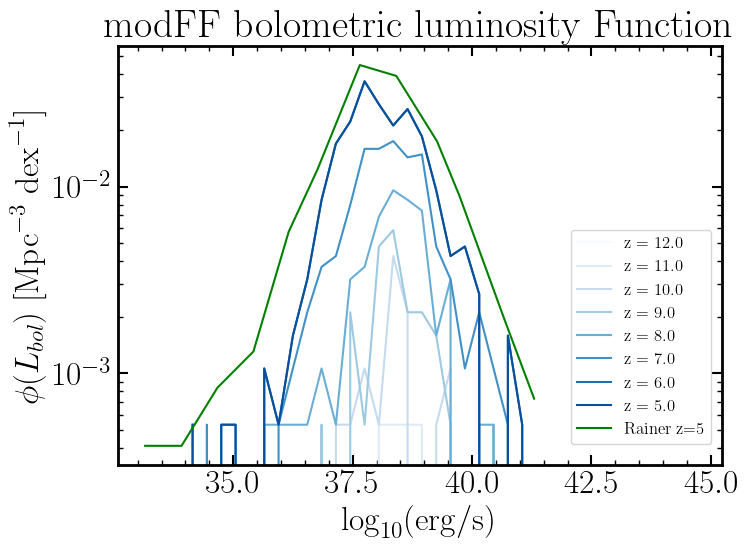

In [12]:
cmap = mpl.colormaps['Blues']

Rainer_modFF_Lf = np.array([33.156726768377254, 0.0004089314245619851,33.91863153028202, 0.0004089314245619851,34.66870087840962, 0.0008362383819915526,35.42320850670365, 0.0013076901556727965,36.16070272769302, 0.005718492467680298,36.757651410078594, 0.012228653538814907,37.650485436893206, 0.04471831562372909,38.414609338881185, 0.039105064784322054,39.26601941747573, 0.01748712629511687,39.73425797503467, 0.008942445678545876,40.20397595931577, 0.004181761147544997,40.67369394359686, 0.0019555194321247984,41.29949144706426, 0.000731269853231323,41.61386962552011, 0.0004089314245619851])
Rainer_modFF_Lf_x = Rainer_modFF_Lf[list(np.arange(0,len(Rainer_modFF_Lf)-2,2))]
Rainer_modFF_Lf_y = Rainer_modFF_Lf[list(np.arange(1,len(Rainer_modFF_Lf)-1,2))]

Rainer_FF_Lf = np.array([34.67387887193713, 0.0006115159188653624,35.44244105409154, 0.0004089314245619851,35.75164123901988, 0.00031271278046105156,37.123069810448456, 0.00031271278046105156,37.33684697179843, 0.000764707140802408,37.77771613499769, 0.002044935487379738,38.53370319001387, 0.0029242831207597826,39.1291724456773, 0.006838352066621672,39.49828941285252, 0.013983988816231214,40.01608876560333, 0.03576004513317583,40.76985668053629, 0.05847770111941951,41.394174757281554, 0.023913369623874223,41.55099398982894, 0.01828672451202402,42.02145168747111, 0.00817751518452874,42.26111881645863, 0.004181761147544997,42.50152565880722, 0.002044935487379738,42.665002311604255, 0.0010457249638055413,43.06000924641702, 0.00044718315623729066])
Rainer_FF_Lf_x = Rainer_FF_Lf[list(np.arange(0,len(Rainer_FF_Lf)-2,2))]
Rainer_FF_Lf_y = Rainer_FF_Lf[list(np.arange(1,len(Rainer_FF_Lf)-1,2))]

plt.figure(figsize=(8, 6))

for i in range(len(redshifts)):
    plt.plot(np.log10(all_bin_centers[i]), Lbolf[i],label = f'z = {redshifts[i]}',color = cmap(i/len(redshifts)))

plt.plot(Rainer_modFF_Lf_x,Rainer_modFF_Lf_y,label = 'Rainer z=5',color='green')
# plt.plot(Rainer_FF_Lf_x,Rainer_FF_Lf_y,label = 'Rainer z=5',color='green')
plt.xlabel(r'$\log_{10}(\rm erg/s)$')
plt.ylabel(r'$\phi(L_{bol})\ [\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1}]$')
plt.title('modFF bolometric luminosity Function')
plt.yscale('log')
plt.tight_layout()
plt.legend(fontsize=12,loc=(0.75,0.05))
plt.savefig(f'{Simpath}/Plots/modFF_Rainer_LbolF.png')

# Making comparison plots

# 3 panel plot

In [13]:
Filepath = '/project/torrey-group/jkho/LtU_accretion' 
Boxes = ['Constrained','Low_mass_seeds','Zooms']
Simpaths = [['Bondi_constrained_noAGN_fewseeds','FF_constrained_noAGN_fewseeds','modFF_constrained_noAGN_fewseeds'],
            ['Bondi_lowmass_noAGN_fewseeds_z127','FF_lowmass_noAGN_fewseeds_z127','modFF_lowmass_noAGN_fewseeds_z127'], # Need FF_lowmass_noAGN_fewseeds_z127!
            ['Bondi_zoom','FF_zoom','modFF_zoom']]  
outputpath = 'output'  # 'Bondi_seed3.19_nofeedback_fewseeds'

redshifts = np.linspace(14,5,10) # np.linspace(12,5,8)
a = 1/(1+redshifts)

Masses_Bondi = []
Mdots_Bondi = []
QM_growth_Bondi = []

Masses_FF = []
Mdots_FF = []
QM_growth_FF = []

Masses_modFF = []
Mdots_modFF = []
QM_growth_modFF = []

for i in range(len(Boxes)):
    box = Boxes[i]

    Bondi_M = []
    FF_M = []
    modFF_M = []

    Bondi_Mdot = []
    FF_Mdot = []
    modFF_Mdot = []

    Bondi_QM = []
    FF_QM = []
    modFF_QM = []
    
    for sim in Simpaths[i]:
    
        basePath = f'{Filepath}/{box}/{sim}/{outputpath}/'
        
        header = arepo_package.load_snapshot_header(basePath,8)
        boxsize = header['BoxSize']
        # boxsize = 3125.0 
        h = 0.6774
        
        for ii in range(len(redshifts)):
            
            BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[ii])
            BH_Mdot = get_particle_property_LTU(basePath,'BH_Mdot',p_type=5, desired_redshift = redshifts[ii])
            BH_QM_Cumgrowth = get_particle_property_LTU(basePath,'BH_CumMassGrowth_QM',p_type=5, desired_redshift = redshifts[ii])
    
            most_massive_ind = np.argmax(BH_Mass[0])
    
            if sim == Simpaths[i][0]:
                Bondi_M.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Bondi_Mdot.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                Bondi_QM.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)
            elif sim == Simpaths[i][1]:
                FF_M.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                FF_Mdot.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                FF_QM.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)
            elif sim == Simpaths[i][2]:
                modFF_M.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                modFF_Mdot.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                modFF_QM.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)

    Masses_Bondi.append(Bondi_M)
    Masses_FF.append(FF_M)
    Masses_modFF.append(modFF_M)
    
    Mdots_Bondi.append(Bondi_Mdot)
    Mdots_FF.append(FF_Mdot)
    Mdots_modFF.append(modFF_Mdot)

    QM_growth_Bondi.append(Bondi_QM)
    QM_growth_FF.append(FF_QM)
    QM_growth_modFF.append(modFF_QM)

Masses_Bondi = np.array(Masses_Bondi)
Mdots_Bondi = np.array(Mdots_Bondi)
QM_growth_Bondi = np.array(QM_growth_Bondi)
Masses_FF = np.array(Masses_FF)
Mdots_FF = np.array(Mdots_FF)
QM_growth_FF = np.array(QM_growth_FF)
Masses_modFF = np.array(Masses_modFF)
Mdots_modFF = np.array(Mdots_modFF)
QM_growth_modFF = np.array(QM_growth_modFF)


Desired redshift:  8
Output redshift:  8.017333353397985
Output snapshot:  17
{'BoxSize': np.float64(9000.0), 'MassTable': array([0.        , 0.00011289, 0.        , 0.        , 0.        ,
       0.        ]), 'NumFilesPerSnapshot': np.int32(16), 'NumPart_ThisFile': array([2870556, 2916484,       0,       0,   13118,       1], dtype=uint64), 'NumPart_Total': array([46053143, 46656000,        0,        0,   163196,       13],
      dtype=uint64), 'Redshift': np.float64(8.017333353397985), 'Time': np.float64(0.1108975304348898)}
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' obje

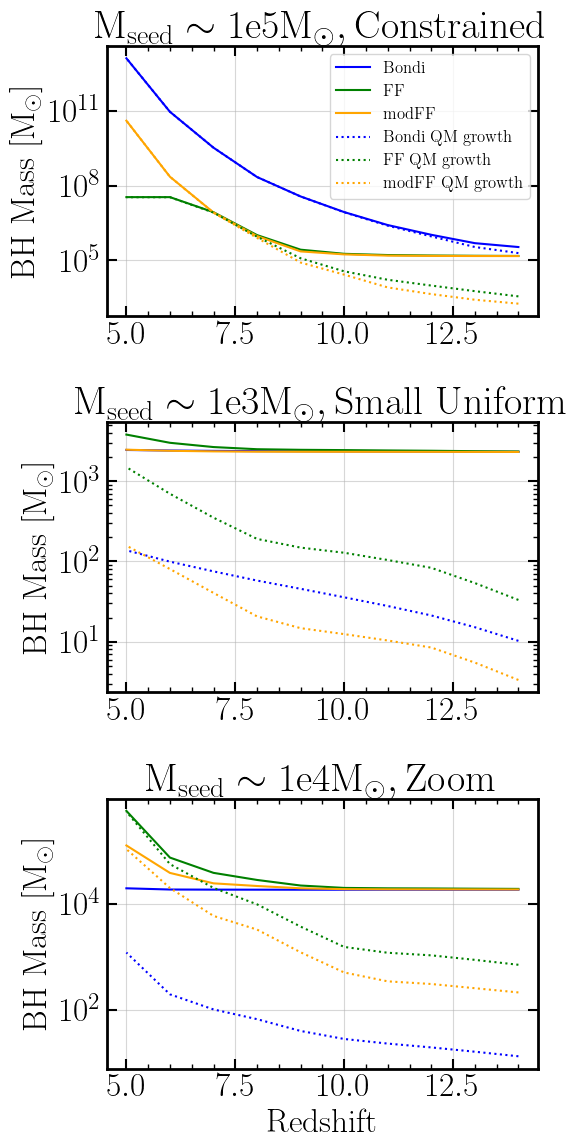

In [17]:
# seed_mass = 1.5625e-07 #  1e-05  # 8.0e-8*1e10/h # 
# merger_driven_growth = seed_mass*(np.array(Progs) - 1)
titles = [r'$\rm M_{seed}\sim 1e5 M_\odot, Constrained$',
          r'$\rm M_{seed}\sim 1e3 M_\odot, Small\ Uniform$',
         r'$\rm M_{seed}\sim 1e4 M_\odot, Zoom$']

fig,axs = plt.subplots(3,1,figsize=(6,12))

axs[0].plot(redshifts,Masses_Bondi[0],label = 'Bondi',color='blue')
axs[0].plot(redshifts,Masses_FF[0],label = 'FF',color='green')
axs[0].plot(redshifts,Masses_modFF[0],label = 'modFF',color='orange')
axs[0].plot(redshifts,QM_growth_Bondi[0],label = 'Bondi QM growth',ls = ':',color='blue')
axs[0].plot(redshifts,QM_growth_FF[0],label = 'FF QM growth',ls = ':',color='green')
axs[0].plot(redshifts,QM_growth_modFF[0],label = 'modFF QM growth',ls = ':',color='orange')

axs[1].plot(redshifts,Masses_Bondi[1],label = 'Bondi',color='blue')
axs[1].plot(redshifts,Masses_FF[1],label = 'FF',color='green')
axs[1].plot(redshifts,Masses_modFF[1],label = 'modFF',color='orange')
axs[1].plot(redshifts,QM_growth_Bondi[1],label = 'Bondi QM growth',ls = ':',color='blue')
axs[1].plot(redshifts,QM_growth_FF[1],label = 'FF QM growth',ls = ':',color='green')
axs[1].plot(redshifts,QM_growth_modFF[1],label = 'modFF QM growth',ls = ':',color='orange')

axs[2].plot(redshifts,Masses_Bondi[2],label = 'Bondi',color='blue')
axs[2].plot(redshifts,Masses_FF[2],label = 'FF',color='green')
axs[2].plot(redshifts,Masses_modFF[2],label = 'modFF',color='orange')
axs[2].plot(redshifts,QM_growth_Bondi[2],label = 'Bondi QM growth',ls = ':',color='blue')
axs[2].plot(redshifts,QM_growth_FF[2],label = 'FF QM growth',ls = ':',color='green')
axs[2].plot(redshifts,QM_growth_modFF[2],label = 'modFF QM growth',ls = ':',color='orange')

axs[0].legend(fontsize=12)
axs[2].set_xlabel('Redshift')

for i in range(len(axs)):
    axs[i].set_yscale('log')
    axs[i].set_ylabel(r'BH Mass [$\rm M_\odot$]')
    axs[i].set_title(f'{titles[i]}')
    axs[i].grid(alpha=0.5)

fig.tight_layout()
fig.savefig(f'Plots/All_BH_growth_comparison.png')

# Comparing growth for lenient vs strict seeding

In [3]:
Filepath = '/project/torrey-group/jkho/LtU_accretion' 
Box ='Constrained' #  'Low_mass_seeds' # 'Zooms' # 

# [Strict, Lenient]
if Box == 'Low_mass_seeds':
    Simpaths = [['Bondi_lowmass_AGN_fewseeds_z127','FF_lowmass_AGN_fewseeds_z127','modFF_lowmass_AGN_fewseeds_z127'],['Bondi_lowmass_AGN_stellar_lenient','FF_lowmass_AGN_stellar_lenient','modFF_lowmass_AGN_stellar_lenient']] 
elif Box == 'Zooms':
    Simpaths = [['Bondi_zoom_AGN','FF_zoom_AGN','modFF_zoom_AGN'],['Bondi_zoom_AGN_stellar_lenient','FF_zoom_AGN_stellar_lenient','modFF_zoom_AGN_stellar_lenient']]   
elif Box == 'Constrained':
    Simpaths = [['Bondi_constrained_AGN_fewseeds_stellar','FF_constrained_AGN_fewseeds_stellar','modFF_constrained_AGN_fewseeds_stellar'],['Bondi_constrained_AGN_stellar_lenient','FF_constrained_AGN_stellar_lenient','modFF_constrained_AGN_stellar_lenient']]  

outputpath = 'output'  # 'Bondi_seed3.19_nofeedback_fewseeds'

redshifts = np.linspace(15,6,10) # np.linspace(12,5,8)
a = 1/(1+redshifts)

Masses_Bondi = []
Mdots_Bondi = []
QM_growth_Bondi = []

Masses_FF = []
Mdots_FF = []
QM_growth_FF = []

Masses_modFF = []
Mdots_modFF = []
QM_growth_modFF = []

for ii in range(len(Simpaths)):

    Masses_Bondi_i = []
    Mdots_Bondi_i = []
    QM_growth_Bondi_i = []

    Masses_FF_i = []
    Mdots_FF_i = []
    QM_growth_FF_i = []

    Masses_modFF_i = []
    Mdots_modFF_i = []
    QM_growth_modFF_i = []

    for sim in Simpaths[ii]:
    
        basePath = f'{Filepath}/{Box}/{sim}/{outputpath}/'
        
        header = arepo_package.load_snapshot_header(basePath,8)
        boxsize = header['BoxSize']
        # boxsize = 3125.0 
        h = 0.6774
        
        # data = arepo_package.get_seeding_events2(basePath)

        for i in range(len(redshifts)):
            
            BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[i])
            BH_Mdot = get_particle_property_LTU(basePath,'BH_Mdot',p_type=5, desired_redshift = redshifts[i])
            BH_QM_Cumgrowth = get_particle_property_LTU(basePath,'BH_CumMassGrowth_QM',p_type=5, desired_redshift = redshifts[i])
            
            most_massive_ind = np.argmax(BH_Mass[0])
    
            if sim == Simpaths[ii][0]:
                Masses_Bondi_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Mdots_Bondi_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                QM_growth_Bondi_i.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)
            elif sim == Simpaths[ii][1]:
                Masses_FF_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Mdots_FF_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                QM_growth_FF_i.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)
            elif sim == Simpaths[ii][2]:
                Masses_modFF_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Mdots_modFF_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                QM_growth_modFF_i.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)

    Masses_Bondi.append(Masses_Bondi_i)
    Mdots_Bondi.append(Mdots_Bondi_i)
    QM_growth_Bondi.append(QM_growth_Bondi_i)
    
    Masses_FF.append(Masses_FF_i)
    Mdots_FF.append(Mdots_FF_i)
    QM_growth_FF.append(QM_growth_FF_i)
    
    Masses_modFF.append(Masses_modFF_i)
    Mdots_modFF.append(Mdots_modFF_i)
    QM_growth_modFF.append(QM_growth_modFF_i)

Masses_Bondi = np.array(Masses_Bondi)
Mdots_Bondi = np.array(Mdots_Bondi)
QM_growth_Bondi = np.array(QM_growth_Bondi)
Masses_FF = np.array(Masses_FF)
Mdots_FF = np.array(Mdots_FF)
QM_growth_FF = np.array(QM_growth_FF)
Masses_modFF = np.array(Masses_modFF)
Mdots_modFF = np.array(Mdots_modFF)
QM_growth_modFF = np.array(QM_growth_modFF)

Desired redshift:  8
Output redshift:  8.017333353397985
Output snapshot:  17
{'BoxSize': np.float64(9000.0), 'MassTable': array([0.        , 0.00011289, 0.        , 0.        , 0.        ,
       0.        ]), 'NumFilesPerSnapshot': np.int32(16), 'NumPart_ThisFile': array([2875138, 2919963,       0,       0,   13204,       0], dtype=uint64), 'NumPart_Total': array([46043014, 46656000,        0,        0,   174806,        8],
      dtype=uint64), 'Redshift': np.float64(8.017333353397985), 'Time': np.float64(0.1108975304348898)}
Desired redshift:  8
Output redshift:  8.017333353397985
Output snapshot:  17
{'BoxSize': np.float64(9000.0), 'MassTable': array([0.        , 0.00011289, 0.        , 0.        , 0.        ,
       0.        ]), 'NumFilesPerSnapshot': np.int32(16), 'NumPart_ThisFile': array([2884377, 2925224,       0,       0,    6330,       0], dtype=uint64), 'NumPart_Total': array([46053141, 46656000,        0,        0,   165675,        9],
      dtype=uint64), 'Redshift': np.

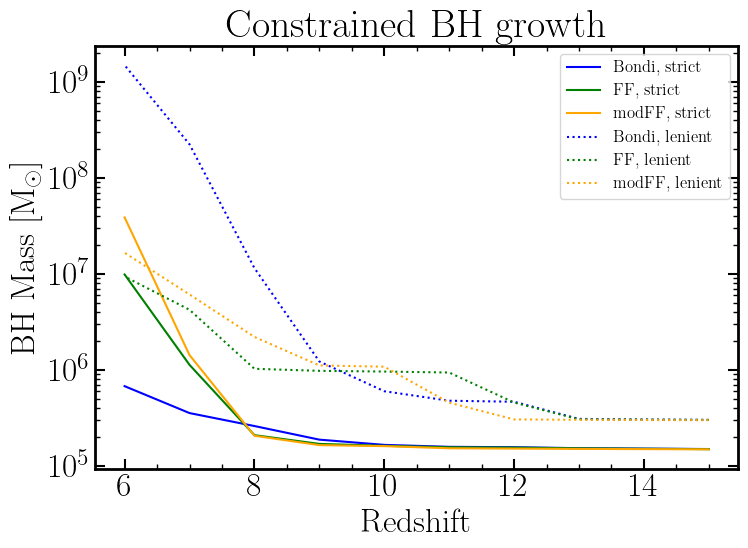

In [5]:
# seed_mass = 1.5625e-07 #  1e-05  # 8.0e-8*1e10/h # 
# merger_driven_growth = seed_mass*(np.array(Progs) - 1)

plt.figure(figsize=(8,6))

# plt.plot(redshifts,QM_growth_Bondi[0],label = 'Bondi, strict',color='blue')
# plt.plot(redshifts,QM_growth_FF[0],label = 'FF, strict',color='green')
# plt.plot(redshifts,QM_growth_modFF[0],label = 'modFF, strict',color='orange')

# plt.plot(redshifts,QM_growth_Bondi[1],label = 'Bondi, lenient',ls = ':',color='blue')
# plt.plot(redshifts,QM_growth_FF[1],label = 'FF, lenient',ls = ':',color='green')
# plt.plot(redshifts,QM_growth_modFF[1],label = 'modFF, lenient',ls = ':',color='orange')

plt.plot(redshifts,Masses_Bondi[0],label = 'Bondi, strict',color='blue')
plt.plot(redshifts,Masses_FF[0],label = 'FF, strict',color='green')
plt.plot(redshifts,Masses_modFF[0],label = 'modFF, strict',color='orange')

plt.plot(redshifts,Masses_Bondi[1],label = 'Bondi, lenient',ls = ':',color='blue')
plt.plot(redshifts,Masses_FF[1],label = 'FF, lenient',ls = ':',color='green')
plt.plot(redshifts,Masses_modFF[1],label = 'modFF, lenient',ls = ':',color='orange')

plt.legend(fontsize=12,loc=1)
plt.yscale('log')
plt.ylabel(r'BH Mass [$\rm M_\odot$]')
plt.xlabel('Redshift')
plt.title(f'{Box} BH growth')
# plt.grid(alpha=0.5)
# plt.text(8.5,5e2,'Bondi boost = 100',fontsize=13)
# plt.ylim(1.5e4,1e5)
# plt.yscale('log')

plt.tight_layout()
plt.savefig(f'Plots/{Box}_lenient_growth_comparison.png')

In [3]:
Filepath = '/project/torrey-group/jkho/LtU_accretion' 
Boxes = ['Low_mass_seeds', 'Zooms', 'Constrained']

outputpath = 'output'  # 'Bondi_seed3.19_nofeedback_fewseeds'

redshifts = np.linspace(15,6,10) # np.linspace(12,5,8)
a = 1/(1+redshifts)

Masses_Bondi = []
Mdots_Bondi = []
QM_growth_Bondi = []

Masses_FF = []
Mdots_FF = []
QM_growth_FF = []

Masses_modFF = []
Mdots_modFF = []
QM_growth_modFF = []

for Box in Boxes:
    # [Strict, Lenient]
    if Box == 'Low_mass_seeds':
        Simpaths = [['Bondi_lowmass_AGN_fewseeds_z127','FF_lowmass_AGN_fewseeds_z127','modFF_lowmass_AGN_fewseeds_z127'],['Bondi_lowmass_AGN_stellar_lenient','FF_lowmass_AGN_stellar_lenient','modFF_lowmass_AGN_stellar_lenient']] 
    elif Box == 'Zooms':
        Simpaths = [['Bondi_zoom_AGN','FF_zoom_AGN','modFF_zoom_AGN'],['Bondi_zoom_AGN_stellar_lenient','FF_zoom_AGN_stellar_lenient','modFF_zoom_AGN_stellar_lenient']]   
    elif Box == 'Constrained':
        Simpaths = [['Bondi_constrained_AGN_fewseeds_stellar','FF_constrained_AGN_fewseeds_stellar','modFF_constrained_AGN_fewseeds_stellar'],['Bondi_constrained_AGN_stellar_lenient','FF_constrained_AGN_stellar_lenient','modFF_constrained_AGN_stellar_lenient']]  

    for ii in range(len(Simpaths)):
    
        Masses_Bondi_i = []
        Mdots_Bondi_i = []
        QM_growth_Bondi_i = []
    
        Masses_FF_i = []
        Mdots_FF_i = []
        QM_growth_FF_i = []
    
        Masses_modFF_i = []
        Mdots_modFF_i = []
        QM_growth_modFF_i = []
    
        for sim in Simpaths[ii]:
        
            basePath = f'{Filepath}/{Box}/{sim}/{outputpath}/'
            
            header = arepo_package.load_snapshot_header(basePath,8)
            boxsize = header['BoxSize']
            # boxsize = 3125.0 
            h = 0.6774
            
            # data = arepo_package.get_seeding_events2(basePath)
    
            for i in range(len(redshifts)):
                
                BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[i])
                BH_Mdot = get_particle_property_LTU(basePath,'BH_Mdot',p_type=5, desired_redshift = redshifts[i])
                BH_QM_Cumgrowth = get_particle_property_LTU(basePath,'BH_CumMassGrowth_QM',p_type=5, desired_redshift = redshifts[i])
                
                most_massive_ind = np.argmax(BH_Mass[0])
        
                if sim == Simpaths[ii][0]:
                    Masses_Bondi_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                    Mdots_Bondi_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                    QM_growth_Bondi_i.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)
                elif sim == Simpaths[ii][1]:
                    Masses_FF_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                    Mdots_FF_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                    QM_growth_FF_i.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)
                elif sim == Simpaths[ii][2]:
                    Masses_modFF_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                    Mdots_modFF_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                    QM_growth_modFF_i.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)
    
        Masses_Bondi.append(Masses_Bondi_i)
        Mdots_Bondi.append(Mdots_Bondi_i)
        QM_growth_Bondi.append(QM_growth_Bondi_i)
        
        Masses_FF.append(Masses_FF_i)
        Mdots_FF.append(Mdots_FF_i)
        QM_growth_FF.append(QM_growth_FF_i)
        
        Masses_modFF.append(Masses_modFF_i)
        Mdots_modFF.append(Mdots_modFF_i)
        QM_growth_modFF.append(QM_growth_modFF_i)

Masses_Bondi = np.array(Masses_Bondi)
Mdots_Bondi = np.array(Mdots_Bondi)
QM_growth_Bondi = np.array(QM_growth_Bondi)
Masses_FF = np.array(Masses_FF)
Mdots_FF = np.array(Mdots_FF)
QM_growth_FF = np.array(QM_growth_FF)
Masses_modFF = np.array(Masses_modFF)
Mdots_modFF = np.array(Mdots_modFF)
QM_growth_modFF = np.array(QM_growth_modFF)

Desired redshift:  8
Output redshift:  8.012172948865935
Output snapshot:  17
{'BoxSize': np.float64(3125.0), 'MassTable': array([0.00000000e+00, 1.64251077e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]), 'NumFilesPerSnapshot': np.int32(16), 'NumPart_ThisFile': array([8297748, 8438981,       0,       0,    1777,       2], dtype=uint64), 'NumPart_Total': array([132708005, 134217728,         0,         0,     19167,        25],
      dtype=uint64), 'Redshift': np.float64(8.012172948865935), 'Time': np.float64(0.11096103078290759)}
Desired redshift:  8
Output redshift:  8.012172948865935
Output snapshot:  17
{'BoxSize': np.float64(3125.0), 'MassTable': array([0.00000000e+00, 1.64251077e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]), 'NumFilesPerSnapshot': np.int32(16), 'NumPart_ThisFile': array([8286284, 8422217,       0,       0,    2698,       7], dtype=uint64), 'NumPart_Total': array([132707167, 134217728,         0,         0

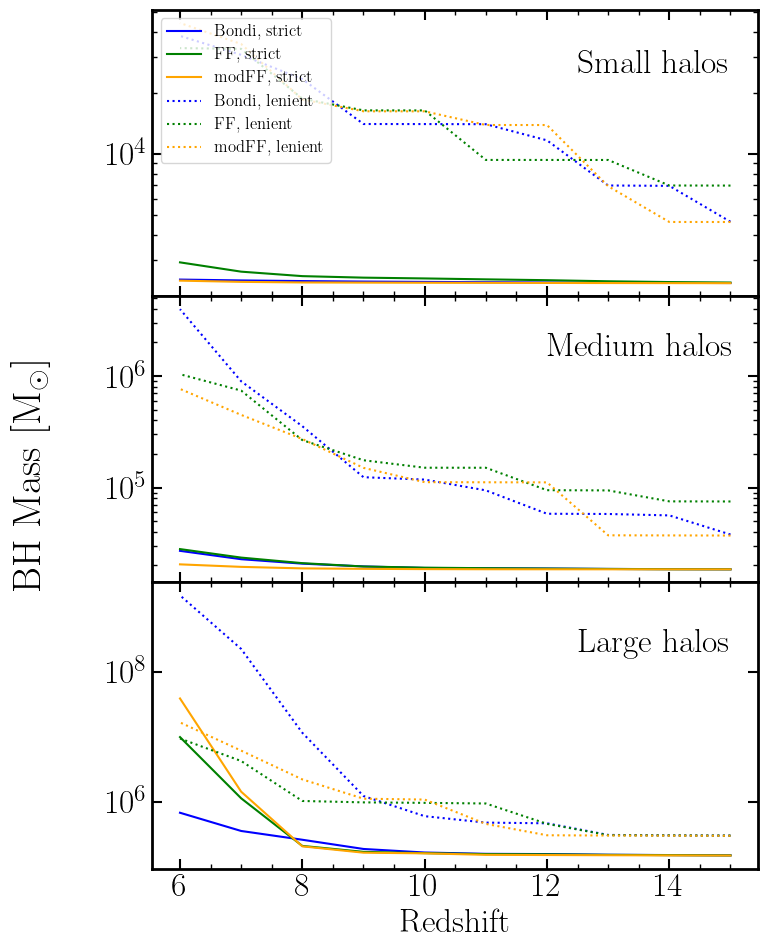

In [9]:
fig,axs = plt.subplots(3,1,figsize=(8,10),sharex=True)

axs[0].plot(redshifts,Masses_Bondi[0],label = 'Bondi, strict',color='blue')
axs[0].plot(redshifts,Masses_FF[0],label = 'FF, strict',color='green')
axs[0].plot(redshifts,Masses_modFF[0],label = 'modFF, strict',color='orange')

axs[0].plot(redshifts,Masses_Bondi[1],label = 'Bondi, lenient',ls = ':',color='blue')
axs[0].plot(redshifts,Masses_FF[1],label = 'FF, lenient',ls = ':',color='green')
axs[0].plot(redshifts,Masses_modFF[1],label = 'modFF, lenient',ls = ':',color='orange')

axs[1].plot(redshifts,Masses_Bondi[2],label = 'Bondi, strict',color='blue')
axs[1].plot(redshifts,Masses_FF[2],label = 'FF, strict',color='green')
axs[1].plot(redshifts,Masses_modFF[2],label = 'modFF, strict',color='orange')

axs[1].plot(redshifts,Masses_Bondi[3],label = 'Bondi, lenient',ls = ':',color='blue')
axs[1].plot(redshifts,Masses_FF[3],label = 'FF, lenient',ls = ':',color='green')
axs[1].plot(redshifts,Masses_modFF[3],label = 'modFF, lenient',ls = ':',color='orange')

axs[2].plot(redshifts,Masses_Bondi[4],label = 'Bondi, strict',color='blue')
axs[2].plot(redshifts,Masses_FF[4],label = 'FF, strict',color='green')
axs[2].plot(redshifts,Masses_modFF[4],label = 'modFF, strict',color='orange')

axs[2].plot(redshifts,Masses_Bondi[5],label = 'Bondi, lenient',ls = ':',color='blue')
axs[2].plot(redshifts,Masses_FF[5],label = 'FF, lenient',ls = ':',color='green')
axs[2].plot(redshifts,Masses_modFF[5],label = 'modFF, lenient',ls = ':',color='orange')

axs[0].text(12.5,2.5e4,'Small halos')
axs[1].text(12,1.5e6,'Medium halos')
axs[2].text(12.5,2e8,'Large halos')

axs[0].legend(fontsize=12,loc=2)
axs[0].set_yscale('log')
fig.supylabel(r'BH Mass [$\rm M_\odot$]')
axs[2].set_xlabel('Redshift')

for ax in axs:
    ax.set_yscale('log')

plt.tight_layout()
plt.subplots_adjust(hspace=0)

plt.savefig(f'Plots/BH_lenient_growth_comparison_all_boxes.png')

# Comparing growth for no AGN vs AGN

In [4]:
Filepath = '/project/torrey-group/jkho/LtU_accretion' 
Box = 'Low_mass_seeds' # 'Zooms' # 'Constrained' # 
Simpaths = [['Bondi_lowmass_noAGN_fewseeds_z127','FF_lowmass_noAGN_fewseeds_z127','modFF_lowmass_noAGN_fewseeds_z127'],['Bondi_lowmass_AGN_fewseeds_z127','FF_lowmass_AGN_fewseeds_z127','modFF_lowmass_AGN_fewseeds_z127']] #[['Bondi_zoom_boost','FF_zoom','modFF_zoom'],['Bondi_zoom_AGN','FF_zoom_AGN','modFF_zoom_AGN']]# ['Bondi_constrained_noAGN_fewseeds','FF_constrained_noAGN_fewseeds','modFF_constrained_noAGN_fewseeds'] #  
outputpath = 'output'  # 'Bondi_seed3.19_nofeedback_fewseeds'

redshifts = np.linspace(17,6,12) # np.linspace(12,5,8)
a = 1/(1+redshifts)

Masses_Bondi = []
Mdots_Bondi = []
QM_growth_Bondi = []
# Bondi_seeds = []

Masses_FF = []
Mdots_FF = []
QM_growth_FF = []
# FF_seeds = []

Masses_modFF = []
Mdots_modFF = []
QM_growth_modFF = []
# modFF_seeds = []

for ii in range(len(Simpaths)):

    Masses_Bondi_i = []
    Mdots_Bondi_i = []
    QM_growth_Bondi_i = []
    # Bondi_seeds_i = []

    Masses_FF_i = []
    Mdots_FF_i = []
    QM_growth_FF_i = []
    # FF_seeds_i = []

    Masses_modFF_i = []
    Mdots_modFF_i = []
    QM_growth_modFF_i = []
    # modFF_seeds_i = []

    for sim in Simpaths[ii]:
    
        basePath = f'{Filepath}/{Box}/{sim}/{outputpath}/'
        
        header = arepo_package.load_snapshot_header(basePath,8)
        boxsize = header['BoxSize']
        # boxsize = 3125.0 
        h = 0.6774
        
        # data = arepo_package.get_seeding_events2(basePath)

        for i in range(len(redshifts)):
            
            BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[i])
            BH_Mdot = get_particle_property_LTU(basePath,'BH_Mdot',p_type=5, desired_redshift = redshifts[i])
            BH_QM_Cumgrowth = get_particle_property_LTU(basePath,'BH_CumMassGrowth_QM',p_type=5, desired_redshift = redshifts[i])
            
            most_massive_ind = np.argmax(BH_Mass[0])
    
            if sim == Simpaths[ii][0]:
                Masses_Bondi_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Mdots_Bondi_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                QM_growth_Bondi_i.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)
            elif sim == Simpaths[ii][1]:
                Masses_FF_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Mdots_FF_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                QM_growth_FF_i.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)
            elif sim == Simpaths[ii][2]:
                Masses_modFF_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Mdots_modFF_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                QM_growth_modFF_i.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)

    Masses_Bondi.append(Masses_Bondi_i)
    Mdots_Bondi.append(Mdots_Bondi_i)
    QM_growth_Bondi.append(QM_growth_Bondi_i)
    
    Masses_FF.append(Masses_FF_i)
    Mdots_FF.append(Mdots_FF_i)
    QM_growth_FF.append(QM_growth_FF_i)
    
    Masses_modFF.append(Masses_modFF_i)
    Mdots_modFF.append(Mdots_modFF_i)
    QM_growth_modFF.append(QM_growth_modFF_i)

Masses_Bondi = np.array(Masses_Bondi)
Mdots_Bondi = np.array(Mdots_Bondi)
QM_growth_Bondi = np.array(QM_growth_Bondi)
Masses_FF = np.array(Masses_FF)
Mdots_FF = np.array(Mdots_FF)
QM_growth_FF = np.array(QM_growth_FF)
Masses_modFF = np.array(Masses_modFF)
Mdots_modFF = np.array(Mdots_modFF)
QM_growth_modFF = np.array(QM_growth_modFF)

Desired redshift:  8
Output redshift:  8.012172948865935
Output snapshot:  17
{'BoxSize': np.float64(3125.0), 'MassTable': array([0.00000000e+00, 1.64251077e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]), 'NumFilesPerSnapshot': np.int32(16), 'NumPart_ThisFile': array([8680390, 8748083,       0,       0,    1823,       1], dtype=uint64), 'NumPart_Total': array([132705610, 134217728,         0,         0,     19160,        26],
      dtype=uint64), 'Redshift': np.float64(8.012172948865935), 'Time': np.float64(0.11096103078290759)}
Current snapshot:  8
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'Non

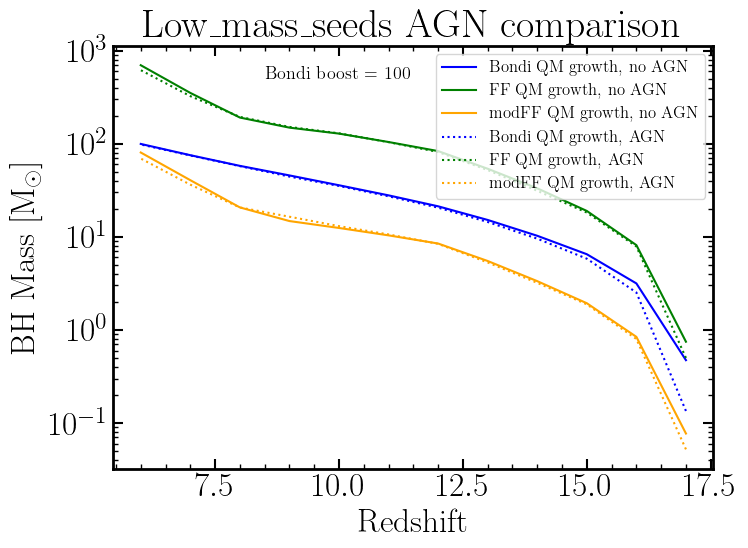

In [12]:
# seed_mass = 1.5625e-07 #  1e-05  # 8.0e-8*1e10/h # 
# merger_driven_growth = seed_mass*(np.array(Progs) - 1)

plt.figure(figsize=(8,6))

plt.plot(redshifts,QM_growth_Bondi[0],label = 'Bondi QM growth, no AGN',color='blue')
plt.plot(redshifts,QM_growth_FF[0],label = 'FF QM growth, no AGN',color='green')
plt.plot(redshifts,QM_growth_modFF[0],label = 'modFF QM growth, no AGN',color='orange')

plt.plot(redshifts,QM_growth_Bondi[1],label = 'Bondi QM growth, AGN',ls = ':',color='blue')
plt.plot(redshifts,QM_growth_FF[1],label = 'FF QM growth, AGN',ls = ':',color='green')
plt.plot(redshifts,QM_growth_modFF[1],label = 'modFF QM growth, AGN',ls = ':',color='orange')

plt.legend(fontsize=12,loc=1)
plt.yscale('log')
plt.ylabel(r'BH Mass [$\rm M_\odot$]')
plt.xlabel('Redshift')
plt.title(f'{Box} AGN comparison')
# plt.grid(alpha=0.5)
plt.text(8.5,5e2,'Bondi boost = 100',fontsize=13)
# plt.ylim(1.5e4,1e5)
# plt.yscale('log')

plt.tight_layout()
plt.savefig(f'Plots/{Box}_AGN_QM_growth_comparison.png')

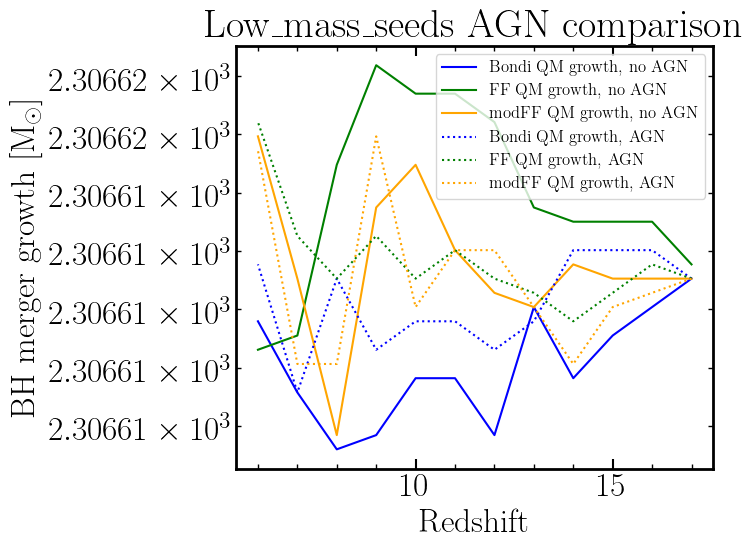

In [17]:
# seed_mass = 1.5625e-07 #  1e-05  # 8.0e-8*1e10/h # 
# merger_driven_growth = seed_mass*(np.array(Progs) - 1)

plt.figure(figsize=(8,6))

plt.plot(redshifts,Masses_Bondi[0] - QM_growth_Bondi[0],label = 'Bondi QM growth, no AGN',color='blue')
plt.plot(redshifts,Masses_FF[0] - QM_growth_FF[0],label = 'FF QM growth, no AGN',color='green')
plt.plot(redshifts,Masses_modFF[0] - QM_growth_modFF[0],label = 'modFF QM growth, no AGN',color='orange')

plt.plot(redshifts,Masses_Bondi[1] - QM_growth_Bondi[1],label = 'Bondi QM growth, AGN',ls = ':',color='blue')
plt.plot(redshifts,Masses_FF[1] - QM_growth_FF[1],label = 'FF QM growth, AGN',ls = ':',color='green')
plt.plot(redshifts,Masses_modFF[1] - QM_growth_modFF[1],label = 'modFF QM growth, AGN',ls = ':',color='orange')

plt.legend(fontsize=12,loc=1)
plt.yscale('log')
plt.ylabel(r'BH merger growth [$\rm M_\odot$]')
plt.xlabel('Redshift')
plt.title(f'{Box} AGN comparison')
# plt.grid(alpha=0.5)
# plt.text(8.5,9e3,'Bondi boost = 100',fontsize=13)
# plt.ylim(2e3,3e3)
# plt.yscale('log')

plt.tight_layout()
plt.savefig(f'Plots/{Box}_AGN_merger_growth_comparison.png')

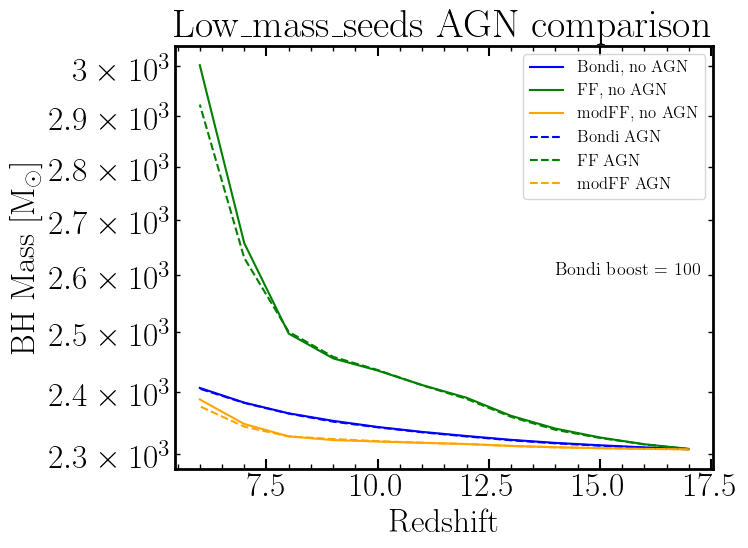

In [19]:
# seed_mass = 1.5625e-07 #  1e-05  # 8.0e-8*1e10/h # 
# merger_driven_growth = seed_mass*(np.array(Progs) - 1)

plt.figure(figsize=(8,6))
plt.plot(redshifts,Masses_Bondi[0],label = 'Bondi, no AGN',color='blue')
plt.plot(redshifts,Masses_FF[0],label = 'FF, no AGN',color='green')
plt.plot(redshifts,Masses_modFF[0],label = 'modFF, no AGN',color='orange')

plt.plot(redshifts,Masses_Bondi[1],label = 'Bondi AGN',color='blue',ls = '--')
plt.plot(redshifts,Masses_FF[1],label = 'FF AGN',color='green',ls = '--')
plt.plot(redshifts,Masses_modFF[1],label = 'modFF AGN',color='orange',ls = '--')

plt.legend(fontsize=12,loc=1)
plt.yscale('log')
plt.ylabel(r'BH Mass [$\rm M_\odot$]')
plt.xlabel('Redshift')
plt.title(f'{Box} AGN comparison')
# plt.grid(alpha=0.5)
plt.text(14,2.6e3,'Bondi boost = 100',fontsize=13)
# plt.ylim(1.5e4,1e5)
# plt.yscale('log')

plt.tight_layout()
plt.savefig(f'Plots/{Box}_AGN_BH_growth_comparison.png')

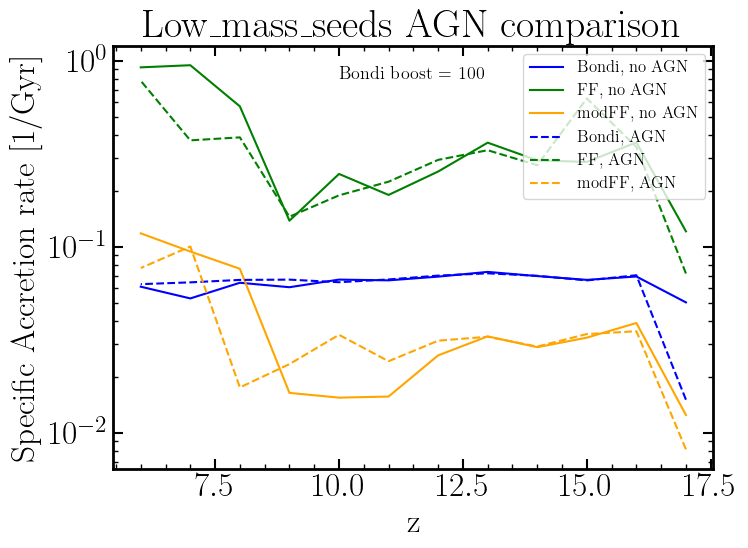

In [20]:
fig,axs = plt.subplots(1,1,figsize = (8,6))

axs.plot(redshifts,Mdots_Bondi[0]/Masses_Bondi[0],label = 'Bondi, no AGN',color='blue')
axs.plot(redshifts,Mdots_FF[0]/Masses_FF[0],label = 'FF, no AGN',color='green')
axs.plot(redshifts,Mdots_modFF[0]/Masses_modFF[0],label = 'modFF, no AGN',color='orange')

axs.plot(redshifts,Mdots_Bondi[1]/Masses_Bondi[1],label = 'Bondi, AGN',ls = '--',color='blue')
axs.plot(redshifts,Mdots_FF[1]/Masses_FF[1],label = 'FF, AGN',ls = '--',color='green')
axs.plot(redshifts,Mdots_modFF[1]/Masses_modFF[1],label = 'modFF, AGN',ls = '--',color='orange')

axs.set_xlabel('z')
axs.set_ylabel('Specific Accretion rate [1/Gyr]')
axs.set_yscale('log')
axs.set_title(f'{Box} AGN comparison')
axs.text(10,0.8,'Bondi boost = 100',fontsize=13)
axs.legend(fontsize=12,loc=1)

fig.tight_layout()
fig.savefig(f'Plots/{Box}_AGN_Specific_comparison.png')

# Comparing no stellar vs stellar feedback

In [11]:
Filepath = '/project/torrey-group/jkho/LtU_accretion' 
Box = 'Zooms' # 'Low_mass_seeds' # 'Constrained' # 
Simpaths = [['Bondi_zoom_AGN','FF_zoom_AGN','modFF_zoom_AGN'],['Bondi_zoom_AGN_0.1stellar','FF_zoom_AGN_0.1stellar','modFF_zoom_AGN_0.1stellar']] # [['Bondi_lowmass_noAGN_fewseeds_z127','FF_lowmass_noAGN_fewseeds_z127','modFF_lowmass_noAGN_fewseeds_z127'],['Bondi_lowmass_noAGN_fewseeds_nostellar_z127','FF_lowmass_noAGN_fewseeds_nostellar_z127','modFF_lowmass_noAGN_fewseeds_nostellar_z127']]# ['Bondi_constrained_noAGN_fewseeds','FF_constrained_noAGN_fewseeds','modFF_constrained_noAGN_fewseeds'] # ['Bondi_lowmass_noAGN_z127','FF_lowmass_noAGN','modFF_lowmass_noAGN'] # 
outputpath = 'output'  # 'Bondi_seed3.19_nofeedback_fewseeds'

redshifts = np.linspace(14,7,8) # np.linspace(12,5,8)
a = 1/(1+redshifts)

Masses_Bondi = []
Mdots_Bondi = []
QM_growth_Bondi = []
Edd_Bondi = []

Masses_FF = []
Mdots_FF = []
QM_growth_FF = []
Edd_FF = []

Masses_modFF = []
Mdots_modFF = []
QM_growth_modFF = []
Edd_modFF = []

for ii in range(len(Simpaths)):

    Masses_Bondi_i = []
    Mdots_Bondi_i = []
    QM_growth_Bondi_i = []
    Edd_Bondi_i = []

    Masses_FF_i = []
    Mdots_FF_i = []
    QM_growth_FF_i = []
    Edd_FF_i = []

    Masses_modFF_i = []
    Mdots_modFF_i = []
    QM_growth_modFF_i = []
    Edd_modFF_i = []

    for sim in Simpaths[ii]:
    
        basePath = f'{Filepath}/{Box}/{sim}/{outputpath}/'
        
        header = arepo_package.load_snapshot_header(basePath,8)
        boxsize = header['BoxSize']
        # boxsize = 3125.0 
        h = 0.6774
        
        for i in range(len(redshifts)):
            
            BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[i])
            BH_Mdot = get_particle_property_LTU(basePath,'BH_Mdot',p_type=5, desired_redshift = redshifts[i])
            BH_QM_Cumgrowth = get_particle_property_LTU(basePath,'BH_CumMassGrowth_QM',p_type=5, desired_redshift = redshifts[i])
            BH_Edd = get_particle_property_LTU(basePath,'BH_MdotEddington',p_type=5, desired_redshift = redshifts[i])
            
            most_massive_ind = np.argmax(BH_Mass[0])
    
            if sim == Simpaths[ii][0]:
                Masses_Bondi_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Mdots_Bondi_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                QM_growth_Bondi_i.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)
                Edd_Bondi_i.append(BH_Edd[0][most_massive_ind]*1e10/0.978)
            elif sim == Simpaths[ii][1]:
                Masses_FF_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Mdots_FF_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                QM_growth_FF_i.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)
                Edd_FF_i.append(BH_Edd[0][most_massive_ind]*1e10/0.978)
            elif sim == Simpaths[ii][2]:
                Masses_modFF_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Mdots_modFF_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                QM_growth_modFF_i.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h)
                Edd_modFF_i.append(BH_Edd[0][most_massive_ind]*1e10/0.978)

    Masses_Bondi.append(Masses_Bondi_i)
    Mdots_Bondi.append(Mdots_Bondi_i)
    QM_growth_Bondi.append(QM_growth_Bondi_i)
    Edd_Bondi.append(Edd_Bondi_i)
    
    Masses_FF.append(Masses_FF_i)
    Mdots_FF.append(Mdots_FF_i)
    QM_growth_FF.append(QM_growth_FF_i)
    Edd_FF.append(Edd_FF_i)
    
    Masses_modFF.append(Masses_modFF_i)
    Mdots_modFF.append(Mdots_modFF_i)
    QM_growth_modFF.append(QM_growth_modFF_i)
    Edd_modFF.append(Edd_modFF_i)
    
Masses_Bondi = np.array(Masses_Bondi)
Mdots_Bondi = np.array(Mdots_Bondi)
QM_growth_Bondi = np.array(QM_growth_Bondi)
Masses_FF = np.array(Masses_FF)
Mdots_FF = np.array(Mdots_FF)
QM_growth_FF = np.array(QM_growth_FF)
Masses_modFF = np.array(Masses_modFF)
Mdots_modFF = np.array(Mdots_modFF)
QM_growth_modFF = np.array(QM_growth_modFF)
Edd_Bondi = np.array(Edd_Bondi)
Edd_FF = np.array(Edd_FF)
Edd_modFF = np.array(Edd_modFF)

Desired redshift:  8
Output redshift:  8.012172948865935
Output snapshot:  17
{'BoxSize': np.float64(25000.0), 'MassTable': array([0.00000000e+00, 1.31400861e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]), 'NumFilesPerSnapshot': np.int32(16), 'NumPart_ThisFile': array([2285184, 2046654,  282469,       0,   14691,       2], dtype=uint64), 'NumPart_Total': array([36654799, 33212696,  4195263,        0,   177682,       15],
      dtype=uint64), 'Redshift': np.float64(8.012172948865935), 'Time': np.float64(0.11096103078290759)}
Current snapshot:  11
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneType' object has no attribute 'get'
'NoneTyp

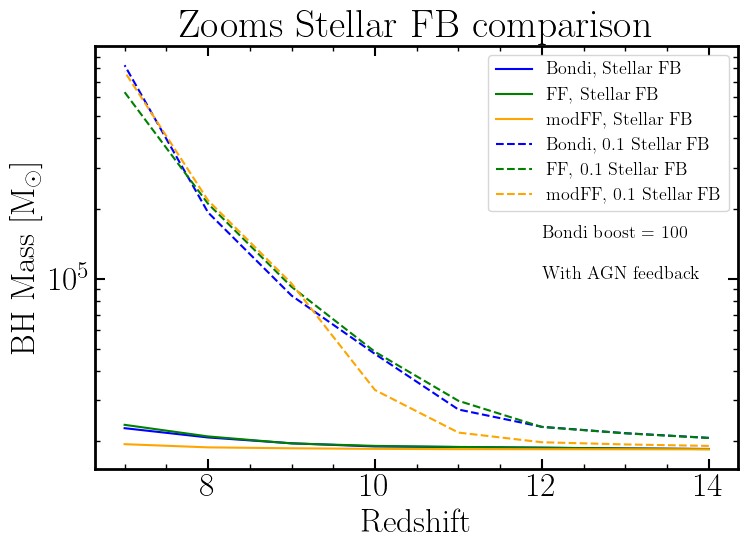

In [7]:
# seed_mass = 1.5625e-07 #  1e-05  # 8.0e-8*1e10/h # 
# merger_driven_growth = seed_mass*(np.array(Progs) - 1)

plt.figure(figsize=(8,6))
plt.plot(redshifts,Masses_Bondi[0],label = 'Bondi, Stellar FB',color='blue')
plt.plot(redshifts,Masses_FF[0],label = 'FF, Stellar FB',color='green')
plt.plot(redshifts,Masses_modFF[0],label = 'modFF, Stellar FB',color='orange')

plt.plot(redshifts,Masses_Bondi[1],label = 'Bondi, 0.1 Stellar FB',color='blue',ls = '--')
plt.plot(redshifts,Masses_FF[1],label = 'FF, 0.1 Stellar FB',color='green',ls = '--')
plt.plot(redshifts,Masses_modFF[1],label = 'modFF, 0.1 Stellar FB',color='orange',ls = '--')

# plt.plot(redshifts,QM_growth_Bondi[0],label = 'Bondi QM growth, no AGN',color='blue')
# plt.plot(redshifts,QM_growth_FF[0],label = 'FF QM growth, no AGN',color='green')
# plt.plot(redshifts,QM_growth_modFF[0],label = 'modFF QM growth, no AGN',color='orange')

# plt.plot(redshifts,QM_growth_Bondi[1],label = 'Bondi QM growth, AGN',ls = ':',color='blue')
# plt.plot(redshifts,QM_growth_FF[1],label = 'FF QM growth, AGN',ls = ':',color='green')
# plt.plot(redshifts,QM_growth_modFF[1],label = 'modFF QM growth, AGN',ls = ':',color='orange')

plt.legend(fontsize=13)
plt.yscale('log')
plt.ylabel(r'BH Mass [$\rm M_\odot$]')
plt.xlabel('Redshift')
plt.title(f'{Box} Stellar FB comparison')
# plt.grid(alpha=0.5)
plt.text(12,1.5e5,'Bondi boost = 100',fontsize=13)
plt.text(12,1e5,'With AGN feedback',fontsize=13)
# plt.ylim(1.5e4,1e5)

plt.tight_layout()
plt.savefig(f'Plots/{Box}_StellarFB_BH_growth_comparison.png')

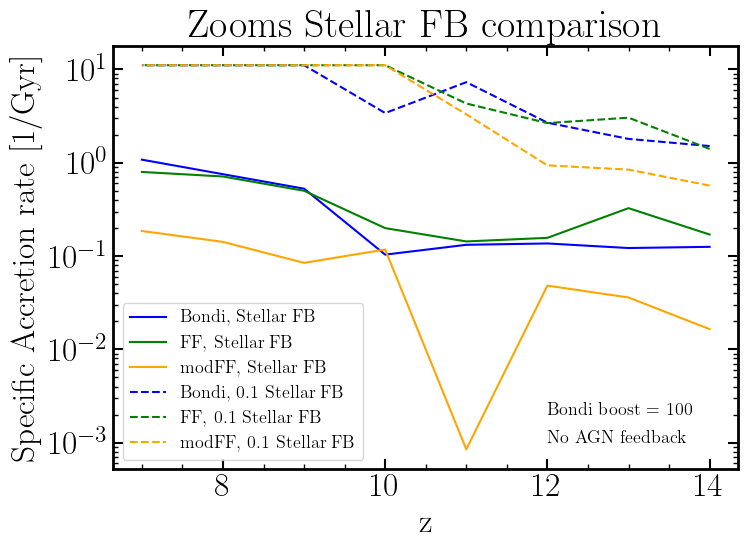

In [10]:
fig,axs = plt.subplots(1,1,figsize = (8,6))

axs.plot(redshifts,Mdots_Bondi[0]/Masses_Bondi[0],label = 'Bondi, Stellar FB',color='blue')
axs.plot(redshifts,Mdots_FF[0]/Masses_FF[0],label = 'FF, Stellar FB',color='green')
axs.plot(redshifts,Mdots_modFF[0]/Masses_modFF[0],label = 'modFF, Stellar FB',color='orange')

axs.plot(redshifts,Mdots_Bondi[1]/Masses_Bondi[1],label = 'Bondi, 0.1 Stellar FB',ls = '--',color='blue')
axs.plot(redshifts,Mdots_FF[1]/Masses_FF[1],label = 'FF, 0.1 Stellar FB',ls = '--',color='green')
axs.plot(redshifts,Mdots_modFF[1]/Masses_modFF[1],label = 'modFF, 0.1 Stellar FB',ls = '--',color='orange')

axs.set_xlabel('z')
axs.set_ylabel('Specific Accretion rate [1/Gyr]')
axs.set_yscale('log')
axs.set_title(f'{Box} Stellar FB comparison')
axs.text(12,2e-3,'Bondi boost = 100',fontsize=13)
plt.text(12,1e-3,'No AGN feedback',fontsize=13)
axs.legend(fontsize=13)

fig.tight_layout()
fig.savefig(f'Plots/{Box}_StellarFB_Specific_comparison.png')

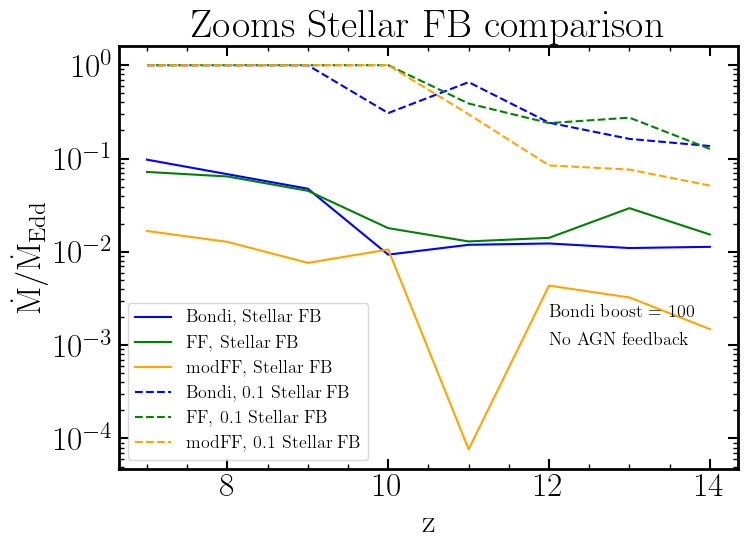

In [12]:
fig,axs = plt.subplots(1,1,figsize = (8,6))

axs.plot(redshifts,Mdots_Bondi[0]/Edd_Bondi[0],label = 'Bondi, Stellar FB',color='blue')
axs.plot(redshifts,Mdots_FF[0]/Edd_FF[0],label = 'FF, Stellar FB',color='green')
axs.plot(redshifts,Mdots_modFF[0]/Edd_modFF[0],label = 'modFF, Stellar FB',color='orange')

axs.plot(redshifts,Mdots_Bondi[1]/Edd_Bondi[1],label = 'Bondi, 0.1 Stellar FB',ls = '--',color='blue')
axs.plot(redshifts,Mdots_FF[1]/Edd_FF[1],label = 'FF, 0.1 Stellar FB',ls = '--',color='green')
axs.plot(redshifts,Mdots_modFF[1]/Edd_modFF[1],label = 'modFF, 0.1 Stellar FB',ls = '--',color='orange')

axs.set_xlabel('z')
axs.set_ylabel(r'$\rm \dot{M}/\dot{M}_{Edd}$')
axs.set_yscale('log')
axs.set_title(f'{Box} Stellar FB comparison')
axs.text(12,2e-3,'Bondi boost = 100',fontsize=13)
plt.text(12,1e-3,'No AGN feedback',fontsize=13)
axs.legend(fontsize=13)

fig.tight_layout()
fig.savefig(f'Plots/{Box}_Eddington_comparison.png')

# Making 2 x 2 plots

In [15]:
Filepath = '/project/torrey-group/jkho/LtU_accretion' 
Box = 'Low_mass_seeds' #

# Order: AGN and stellar, AGN and no stellar, no AGN and stellar, no AGN and no stellar
if Box == 'Zooms':
    Simpaths = [['Bondi_zoom_AGN','FF_zoom_AGN','modFF_zoom_AGN'],
                ['Bondi_zoom_AGN_0.1stellar','FF_zoom_AGN_0.1stellar','modFF_zoom_AGN_0.1stellar'],
                ['Bondi_zoom_boost_noAGN_stellar','FF_zoom_noAGN_stellar','modFF_zoom_noAGN_stellar'],
                ['Bondi_zoom_noAGN_0.1stellar','FF_zoom_noAGN_0.1stellar','modFF_zoom_noAGN_0.1stellar']] # Need no AGN and no stellar
elif Box == 'Low_mass_seeds':
    Simpaths = [['Bondi_lowmass_AGN_fewseeds_z127','FF_lowmass_AGN_fewseeds_z127','modFF_lowmass_AGN_fewseeds_z127'],
                ['Bondi_lowmass_AGN_fewseeds_lowstellar_z127','FF_lowmass_AGN_fewseeds_lowstellar_z127','modFF_lowmass_AGN_fewseeds_lowstellar_z127'], # Need AGN and no stellar
                ['Bondi_lowmass_noAGN_fewseeds_z127','FF_lowmass_noAGN_fewseeds_z127','modFF_lowmass_noAGN_fewseeds_z127'],
                ['Bondi_lowmass_noAGN_fewseeds_lowstellar_z127','FF_lowmass_noAGN_fewseeds_lowstellar_z127','modFF_lowmass_noAGN_fewseeds_lowstellar_z127']]
elif Box == 'Constrained':
    Simpaths = [['Bondi_constrained_AGN_fewseeds_stellar','FF_constrained_AGN_fewseeds_stellar','modFF_constrained_AGN_fewseeds_stellar'],
                ['Bondi_constrained_AGN_fewseeds_0.1stellar','FF_constrained_AGN_fewseeds_0.1stellar','modFF_constrained_AGN_fewseeds_0.1stellar'],
                ['Bondi_constrained_noAGN_fewseeds','FF_constrained_noAGN_fewseeds','modFF_constrained_noAGN_fewseeds'],
                ['Bondi_constrained_noAGN_0.1stellar','FF_constrained_noAGN_0.1stellar','modFF_constrained_noAGN_0.1stellar']]

outputpath = 'output' 

redshifts = np.linspace(19, 6, 14) # redshifts = np.linspace(12,6,7) 
a = 1/(1+redshifts)

Masses_Bondi = []
Mdots_Bondi = []
Accretion_growth_Bondi = []
Edd_Bondi = []
Progs_Bondi = []
# rho_Bondi = []

Masses_FF = []
Mdots_FF = []
Accretion_growth_FF = []
Edd_FF = []
Progs_FF = []
# rho_FF = []

Masses_modFF = []
Mdots_modFF = []
Accretion_growth_modFF = []
Edd_modFF = []
Progs_modFF = []
# rho_modFF = []

for ii in range(len(Simpaths)):

    Masses_Bondi_i = []
    Mdots_Bondi_i = []
    Accretion_growth_Bondi_i = []
    Edd_Bondi_i = []
    Progs_Bondi_i = []
    # rho_Bondi_i = []
    
    Masses_FF_i = []
    Mdots_FF_i = []
    Accretion_growth_FF_i = []
    Edd_FF_i = []
    Progs_FF_i = []
    # rho_FF_i = []

    Masses_modFF_i = []
    Mdots_modFF_i = []
    Accretion_growth_modFF_i = []
    Edd_modFF_i = []
    Progs_modFF_i = []
    # rho_modFF_i = []

    for sim in Simpaths[ii]:
    
        basePath = f'{Filepath}/{Box}/{sim}/{outputpath}/'
        h = 0.6774

        print(f'Now loading data from {sim}')
        
        for i in range(len(redshifts)):
            
            BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[i])
            BH_Mdot = get_particle_property_LTU(basePath,'BH_Mdot',p_type=5, desired_redshift = redshifts[i])
            BH_QM_Cumgrowth = get_particle_property_LTU(basePath,'BH_CumMassGrowth_QM',p_type=5, desired_redshift = redshifts[i])
            BH_RM_Cumgrowth = get_particle_property_LTU(basePath,'BH_CumMassGrowth_RM',p_type=5, desired_redshift = redshifts[i])
            BH_Edd = get_particle_property_LTU(basePath,'BH_MdotEddington',p_type=5, desired_redshift = redshifts[i])
            BH_Progs = get_particle_property_LTU(basePath,'BH_Progs',p_type=5, desired_redshift = redshifts[i]) 
            # BH_rho = get_particle_property_LTU(basePath,'SubfindDensity',p_type=5, desired_redshift = redshifts[i]) 
            most_massive_ind = np.argmax(BH_Mass[0])

            # offset = arepo_package.get_subhalo_property(basePath,'SubhaloOffsetType',desired_redshift = redshifts[i])[0][most_massive_ind]  # array of 6
            # length = arepo_package.get_subhalo_property(basePath,'SubhaloLenType',desired_redshift = redshifts[i])[0][most_massive_ind]
    
            if sim == Simpaths[ii][0]:
                Masses_Bondi_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Mdots_Bondi_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                Accretion_growth_Bondi_i.append((BH_QM_Cumgrowth[0][most_massive_ind] + BH_RM_Cumgrowth[0][most_massive_ind])*1e10/h)
                Edd_Bondi_i.append(BH_Edd[0][most_massive_ind]*1e10/0.978)
                Progs_Bondi_i.append(BH_Progs[0][most_massive_ind])
                # rho_Bondi_i.append(BH_rho[0][most_massive_ind] * (1e10/h)/(a[i]/h)**3) # Msun/kpc^3
            elif sim == Simpaths[ii][1]:
                Masses_FF_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Mdots_FF_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                Accretion_growth_FF_i.append((BH_QM_Cumgrowth[0][most_massive_ind] + BH_RM_Cumgrowth[0][most_massive_ind])*1e10/h)
                Edd_FF_i.append(BH_Edd[0][most_massive_ind]*1e10/0.978)
                Progs_FF_i.append(BH_Progs[0][most_massive_ind])
                # rho_FF_i.append(BH_rho[0][most_massive_ind] * (1e10/h)/(a[i]/h)**3) # Msun/kpc^3
            elif sim == Simpaths[ii][2]:
                Masses_modFF_i.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
                Mdots_modFF_i.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
                Accretion_growth_modFF_i.append((BH_QM_Cumgrowth[0][most_massive_ind] + BH_RM_Cumgrowth[0][most_massive_ind])*1e10/h)
                Edd_modFF_i.append(BH_Edd[0][most_massive_ind]*1e10/0.978)
                Progs_modFF_i.append(BH_Progs[0][most_massive_ind])
                # rho_modFF_i.append(BH_rho[0][most_massive_ind] * (1e10/h)/(a[i]/h)**3) # Msun/kpc^3

    Masses_Bondi.append(Masses_Bondi_i)
    Mdots_Bondi.append(Mdots_Bondi_i)
    Accretion_growth_Bondi.append(Accretion_growth_Bondi_i)
    Edd_Bondi.append(Edd_Bondi_i)
    Progs_Bondi.append(Progs_Bondi_i)
    # rho_Bondi.append(rho_Bondi_i)
    
    Masses_FF.append(Masses_FF_i)
    Mdots_FF.append(Mdots_FF_i)
    Accretion_growth_FF.append(Accretion_growth_FF_i)
    Edd_FF.append(Edd_FF_i)
    Progs_FF.append(Progs_FF_i)
    # rho_FF.append(rho_FF_i)

    Masses_modFF.append(Masses_modFF_i)
    Mdots_modFF.append(Mdots_modFF_i)
    Accretion_growth_modFF.append(Accretion_growth_modFF_i)
    Edd_modFF.append(Edd_modFF_i)
    Progs_modFF.append(Progs_modFF_i)
    # rho_modFF.append(rho_modFF_i)

Masses_Bondi = np.array(Masses_Bondi)
Mdots_Bondi = np.array(Mdots_Bondi)
Accretion_growth_Bondi = np.array(Accretion_growth_Bondi)
Masses_FF = np.array(Masses_FF)
Mdots_FF = np.array(Mdots_FF)
Accretion_growth_FF = np.array(Accretion_growth_FF)
Masses_modFF = np.array(Masses_modFF)
Mdots_modFF = np.array(Mdots_modFF)
Accretion_growth_modFF = np.array(Accretion_growth_modFF)
Edd_Bondi = np.array(Edd_Bondi)
Edd_FF = np.array(Edd_FF)
Edd_modFF = np.array(Edd_modFF)
Progs_Bondi = np.array(Progs_Bondi)
Progs_FF = np.array(Progs_FF)
Progs_modFF = np.array(Progs_modFF)
# rho_Bondi = np.array(rho_Bondi)
# rho_FF = np.array(rho_FF)
# rho_modFF = np.array(rho_modFF)

Now loading data from Bondi_lowmass_AGN_fewseeds_z127
Failed to load BH_Mass at redshift 19.0!
Failed to load BH_Mdot at redshift 19.0!
Failed to load BH_CumMassGrowth_QM at redshift 19.0!
Failed to load BH_CumMassGrowth_RM at redshift 19.0!
Failed to load BH_MdotEddington at redshift 19.0!
Failed to load BH_Progs at redshift 19.0!


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

IndexError: list index out of range

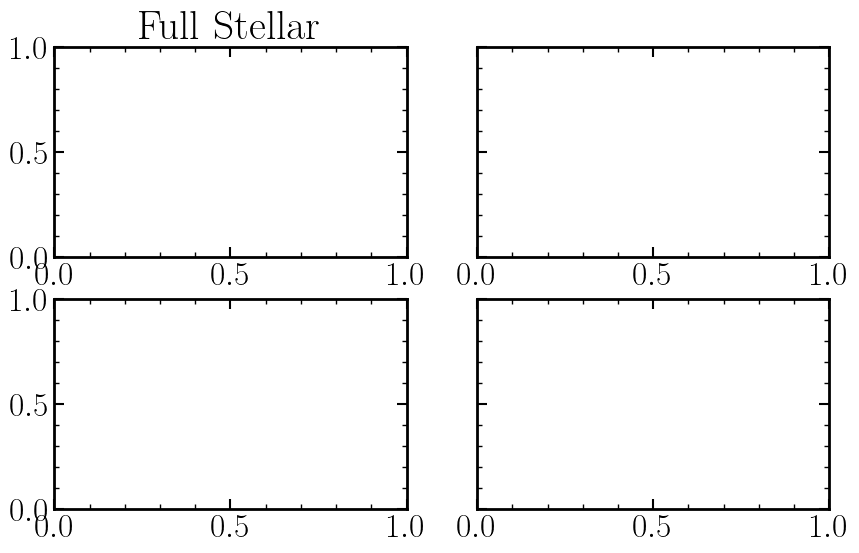

In [14]:
import matplotlib.ticker as mticker

Mseeds = np.array([1e-05,1.25e-06,1.5625e-07])*1e10/h

if Box == 'Low_mass_seeds':
    Mseed = Mseeds[2]
elif Box == 'Zooms':
    Mseed = Mseeds[1]
elif Box == 'Constrained':
    Mseed = Mseeds[0]
      
fig,axs = plt.subplots(2,2,figsize=(10,6),sharey = True)

axs[0,0].set_title('Full Stellar',size=30)
axs[0,0].plot(redshifts,Masses_Bondi[0],color='blue')
axs[0,0].plot(redshifts,Masses_FF[0],color='green')
axs[0,0].plot(redshifts,Masses_modFF[0],label = 'modFF',color='orange')

axs[0,1].set_title('Low Stellar',size=30)
axs[0,1].plot(redshifts,Masses_Bondi[1],label = 'Bondi',color='blue')
axs[0,1].plot(redshifts,Masses_FF[1],label = 'FF',color='green')
axs[0,1].plot(redshifts,Masses_modFF[1],label = 'modFF',color='orange')

axs[1,0].plot(redshifts,Masses_Bondi[2],color='blue')
axs[1,0].plot(redshifts,Masses_FF[2],color='green')
axs[1,0].plot(redshifts,Masses_modFF[2],color='orange')

axs[1,1].plot(redshifts,Masses_Bondi[3],color='blue')
axs[1,1].plot(redshifts,Masses_FF[3],color='green')
axs[1,1].plot(redshifts,Masses_modFF[3],color='orange')

# Plotting QM BH growth
# axs[0,0].plot(redshifts,Mseed + Accretion_growth_Bondi[0],color='blue',ls = ':',lw=3.5)
# axs[0,0].plot(redshifts,Mseed + Accretion_growth_FF[0],color='green',ls = ':',lw=3.5)
# axs[0,0].plot(redshifts,Mseed + Accretion_growth_modFF[0],color='orange',ls = ':',lw=3.5)

# axs[0,1].plot(redshifts,Mseed + Accretion_growth_Bondi[1],ls = ':',color='blue',lw=3.5)
# axs[0,1].plot(redshifts,Mseed + Accretion_growth_FF[1],ls = ':',color='green',lw=3.5)
# axs[0,1].plot(redshifts,Mseed + Accretion_growth_modFF[1],ls = ':',color='orange',lw=3.5)

# axs[1,0].plot(redshifts,Mseed + Accretion_growth_Bondi[2],ls = ':',color='blue',lw=3.5)
# axs[1,0].plot(redshifts,Mseed + Accretion_growth_FF[2],ls = ':',color='green',lw=3.5)
# axs[1,0].plot(redshifts,Mseed + Accretion_growth_modFF[2],ls = ':',color='orange',lw=3.5)

# axs[1,1].plot(redshifts,Mseed + Accretion_growth_Bondi[3],label = 'Bondi Accretion growth',ls = ':',color='blue',lw=3.5)
# axs[1,1].plot(redshifts,Mseed + Accretion_growth_FF[3],label = 'FF Accretion growth',ls = ':',color='green',lw=3.5)
# axs[1,1].plot(redshifts,Mseed + Accretion_growth_modFF[3],label = 'modFF Accretion growth',ls = ':',color='orange',lw=3.5)

for ax in axs.flat:
    ax.set_yscale('log')
    # ax.set_ylim(1e4,5e6) # Zooms
    # ax.set_ylim(2.2e3,1e5) # Low mass seeds
    ax.grid(alpha = 0.5)

# Low mass seeds
# if Box == 'Low_mass_seeds':

#     fig.suptitle(r'Small Uniform, $\rm M_{seed} \approx 10^3M_\odot$',y=0.95,size=35)

# elif Box == 'Constrained':
#     fig.suptitle(r'Constrained volume, $\rm M_{seed} \approx 10^5M_\odot$',y=0.95,size=35)

# elif Box == 'Zooms':
#     fig.suptitle(r'Zoom sims, $\rm M_{seed} \approx 10^4M_\odot$',y=0.95,size=35)
    
axs[1,0].set_xlabel('Redshift',size=20)
axs[1,1].set_xlabel('Redshift',size=20)
axs[0,0].set_ylabel(r'$\rm M_{BH} [M_\odot]$',size=25)
axs[1,0].set_ylabel(r'$\rm M_{BH} [M_\odot]$',size=25)
axs[0,1].set_ylabel('AGN',rotation=270,labelpad=30,size=30)
axs[0,1].yaxis.set_label_position("right")
axs[1,1].set_ylabel('No AGN',rotation=270,labelpad=30,size=30)
axs[1,1].yaxis.set_label_position("right")

fig.text(0.15,0.82,r'Small halos, $\rm M_{seed} \approx 10^3M_\odot$',size=22)

axs[0,1].legend(fontsize=15)
# axs[1,1].legend(fontsize=15)

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

fig.savefig(f'Plots/{Box}_4panel_BH_growth_comparison_z20.png')

## Remaking with loading data:

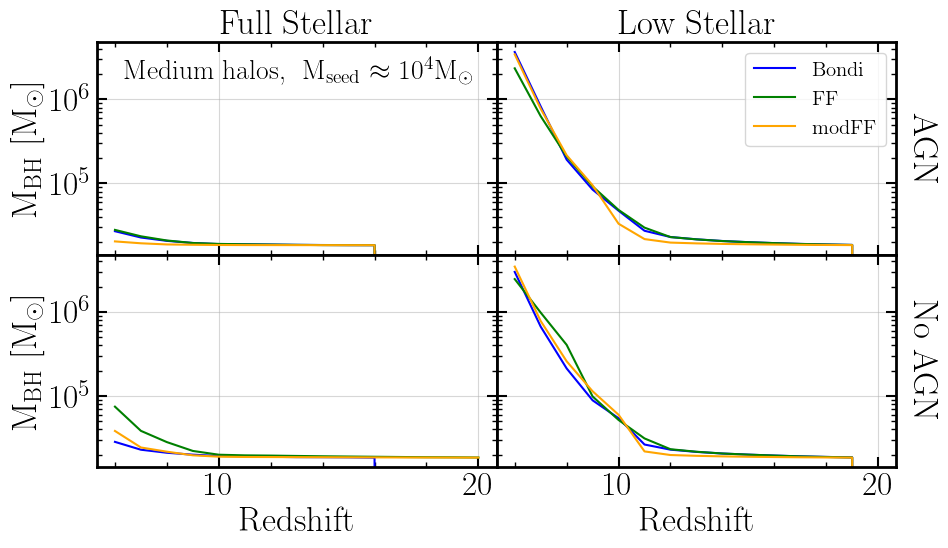

In [30]:
files = ['Constrained','Zooms','Low_mass_seeds']
sim=1
file = files[sim]
divide_by_mass = False

Mseeds = np.array([1e-05,1.25e-06,1.5625e-07])*1e10/h

if divide_by_mass:
    if file == 'Low_mass_seeds':
        Mseed = Mseeds[2]
    elif file == 'Zooms':
        Mseed = Mseeds[1]
    elif file == 'Constrained':
        Mseed = Mseeds[0]
else:
    Mseed = 1
    
h = 0.6774
redshifts = np.linspace(20, 6, 15)

with h5py.File(f"output/{file}_25.hdf5", "r") as f:

    Bondi_AGN_NS_mass = f['AGN_NS']['Bondi']['Masses'][5:]
    Bondi_AGN_S_mass = f['AGN_S']['Bondi']['Masses'][5:]
    Bondi_NAGN_S_mass = f['NAGN_S']['Bondi']['Masses'][5:]
    Bondi_NAGN_NS_mass = f['NAGN_NS']['Bondi']['Masses'][5:]

    FF_AGN_NS_mass = f['AGN_NS']['FF']['Masses'][5:]
    FF_AGN_S_mass = f['AGN_S']['FF']['Masses'][5:]
    FF_NAGN_S_mass = f['NAGN_S']['FF']['Masses'][5:]
    FF_NAGN_NS_mass = f['NAGN_NS']['FF']['Masses'][5:]

    modFF_AGN_NS_mass = f['AGN_NS']['modFF']['Masses'][5:]
    modFF_AGN_S_mass = f['AGN_S']['modFF']['Masses'][5:]
    modFF_NAGN_S_mass = f['NAGN_S']['modFF']['Masses'][5:]
    modFF_NAGN_NS_mass = f['NAGN_NS']['modFF']['Masses'][5:]

fig,axs = plt.subplots(2,2,figsize=(10,6),sharey = True)

axs[0,0].plot(redshifts,Bondi_AGN_S_mass/Mseed,color='blue')
axs[0,0].plot(redshifts,FF_AGN_S_mass/Mseed,color='green')
axs[0,0].plot(redshifts,modFF_AGN_S_mass/Mseed,label = 'modFF',color='orange')

if sim == 0:
    axs[0,1].plot(redshifts[:-2],Bondi_AGN_NS_mass[:-2]/Mseed,label = 'Bondi',color='blue')
else:
    axs[0,1].plot(redshifts,Bondi_AGN_NS_mass/Mseed,label = 'Bondi',color='blue')
axs[0,1].plot(redshifts,FF_AGN_NS_mass/Mseed,label = 'FF',color='green')
axs[0,1].plot(redshifts,modFF_AGN_NS_mass/Mseed,label = 'modFF',color='orange')

axs[1,0].plot(redshifts,Bondi_NAGN_S_mass/Mseed,color='blue')
axs[1,0].plot(redshifts,FF_NAGN_S_mass/Mseed,color='green')
axs[1,0].plot(redshifts,modFF_NAGN_S_mass/Mseed,color='orange')

axs[1,1].plot(redshifts,Bondi_NAGN_NS_mass/Mseed,color='blue')
axs[1,1].plot(redshifts,FF_NAGN_NS_mass/Mseed,color='green')
axs[1,1].plot(redshifts,modFF_NAGN_NS_mass/Mseed,color='orange')

for ax in axs.flat:
    ax.set_yscale('log')
    ax.grid(alpha = 0.5)

# Low mass seeds
if file == 'Low_mass_seeds':
    fig.text(0.15,0.825,r'Small halos, $\rm M_{seed} \approx 10^3M_\odot$',size=20)
    # fig.text(0.15,0.825,r'$\rm M_{halo}\sim 10^6M_\odot,\ M_{seed} \approx 10^3M_\odot$',size=20)
    # fig.suptitle(r'Small Uniform, $\rm M_{seed} \approx 10^3M_\odot$',y=0.93,size=25)

elif file == 'Constrained':
    fig.text(0.15,0.825,r'Large halos, $\rm M_{seed} \approx 10^5M_\odot$',size=20)
    # fig.text(0.15,0.825,r'$\rm M_{halo}\sim 10^8M_\odot,\ M_{seed} \approx 10^5M_\odot$',size=20)
    # fig.suptitle(r'Constrained volume, $\rm M_{seed} \approx 10^5M_\odot$',y=0.93,size=25)

elif file == 'Zooms':
    fig.text(0.15,0.825,r'Medium halos, $\rm \ M_{seed} \approx 10^4M_\odot$',size=20)
    # fig.text(0.15,0.825,r'$\rm M_{halo}\sim 10^7M_\odot,\ M_{seed} \approx 10^4M_\odot$',size=20)
    # fig.suptitle(r'Zoom sims, $\rm M_{seed} \approx 10^4M_\odot$',y=0.93,size=25)

axs[0,0].set_title('Full Stellar',size=25)
axs[0,1].set_title('Low Stellar',size=25)

axs[1,0].set_xlabel('Redshift',size=25)
axs[1,1].set_xlabel('Redshift',size=25)
if divide_by_mass:
    axs[0,0].set_ylabel(r'$\rm M_{BH}/M_{seed}$',size=25)
    axs[1,0].set_ylabel(r'$\rm M_{BH}/M_{seed}$',size=25)
else:
    axs[0,0].set_ylabel(r'$\rm M_{BH}\ [M_\odot]$',size=25)
    axs[1,0].set_ylabel(r'$\rm M_{BH}\ [M_\odot]$',size=25)
axs[0,1].set_ylabel('AGN',rotation=270,labelpad=30,size=25)
axs[0,1].yaxis.set_label_position("right")
axs[1,1].set_ylabel('No AGN',rotation=270,labelpad=30,size=25)
axs[1,1].yaxis.set_label_position("right")

axs[0,1].legend(fontsize=15)
# axs[1,1].legend(fontsize=15)

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

fig.savefig(f'Plots/{file}_4panel_BH_growth_comparison_z20.png')

213.9274729415774 4.572586112772114 621069.1928863524 3156797.4090576167
198.74614663422105 1.4660732631455173 1.540959419799037 162.25945437327024
2.218725239799823 1.0424805623188147 1.043058909999672 38.523395778611295


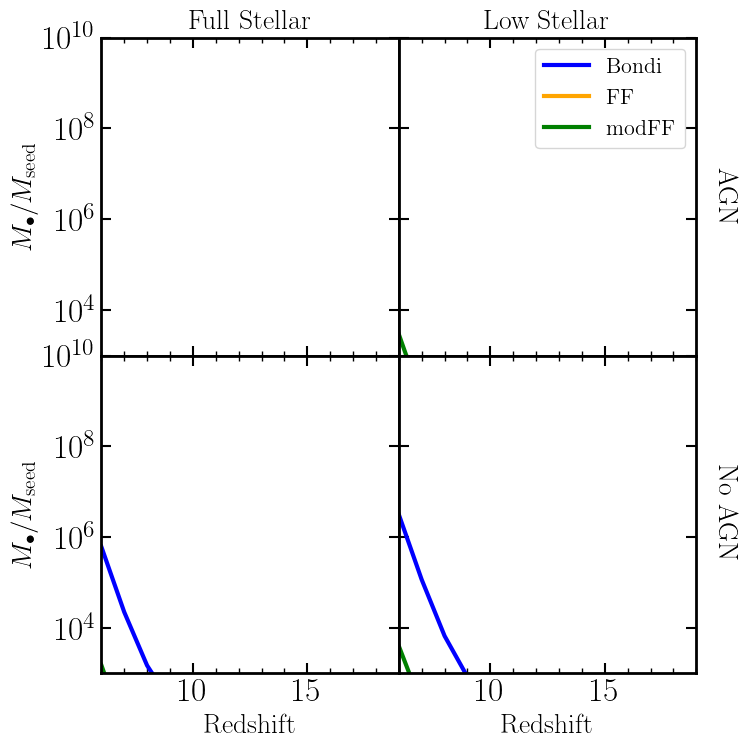

In [4]:
fig, axs = plt.subplots(2,2,figsize = (8,8),sharey = True)

files = ['Constrained','Zooms','Low_mass_seeds']

h = 0.6774
redshifts = np.linspace(19, 6, 14) # redshifts = np.linspace(12, 6, 7)
line_styles = ['-','--',':']
Mseeds = np.array([1e-05,1.25e-06,1.5625e-07]) * 1e10/h
divide_by_mass = True

for i in range(len(files)):

    with h5py.File(f"output/{files[i]}_25.hdf5", "r") as f:

        if divide_by_mass:

            Bondi_AGN_NS_mass = f['AGN_NS']['Bondi']['Masses'][6:]/Mseeds[i]
            Bondi_AGN_S_mass = f['AGN_S']['Bondi']['Masses'][6:]/Mseeds[i]
            Bondi_NAGN_S_mass = f['NAGN_S']['Bondi']['Masses'][6:]/Mseeds[i]
            Bondi_NAGN_NS_mass = f['NAGN_NS']['Bondi']['Masses'][6:]/Mseeds[i]
    
            FF_AGN_NS_mass = f['AGN_NS']['FF']['Masses'][6:]/Mseeds[i]
            FF_AGN_S_mass = f['AGN_S']['FF']['Masses'][6:]/Mseeds[i]
            FF_NAGN_S_mass = f['NAGN_S']['FF']['Masses'][6:]/Mseeds[i]
            FF_NAGN_NS_mass = f['NAGN_NS']['FF']['Masses'][6:]/Mseeds[i]
    
            modFF_AGN_NS_mass = f['AGN_NS']['modFF']['Masses'][6:]/Mseeds[i]
            modFF_AGN_S_mass = f['AGN_S']['modFF']['Masses'][6:]/Mseeds[i]
            modFF_NAGN_S_mass = f['NAGN_S']['modFF']['Masses'][6:]/Mseeds[i]
            modFF_NAGN_NS_mass = f['NAGN_NS']['modFF']['Masses'][6:]/Mseeds[i]
            print(np.max(Bondi_AGN_NS_mass),np.max(Bondi_AGN_S_mass),np.max(Bondi_NAGN_S_mass),np.max(Bondi_NAGN_NS_mass))
        else:
            Bondi_AGN_NS_mass = f['AGN_NS']['Bondi']['Masses'][6:]
            Bondi_AGN_S_mass = f['AGN_S']['Bondi']['Masses'][6:]            
            Bondi_NAGN_S_mass = f['NAGN_S']['Bondi']['Masses'][6:]
            Bondi_NAGN_NS_mass = f['NAGN_NS']['Bondi']['Masses'][6:]
    
            FF_AGN_NS_mass = f['AGN_NS']['FF']['Masses'][6:]
            FF_AGN_S_mass = f['AGN_S']['FF']['Masses'][6:]
            FF_NAGN_S_mass = f['NAGN_S']['FF']['Masses'][6:]
            FF_NAGN_NS_mass = f['NAGN_NS']['FF']['Masses'][6:]
    
            modFF_AGN_NS_mass = f['AGN_NS']['modFF']['Masses'][6:]
            modFF_AGN_S_mass = f['AGN_S']['modFF']['Masses'][6:]
            modFF_NAGN_S_mass = f['NAGN_S']['modFF']['Masses'][6:]
            modFF_NAGN_NS_mass = f['NAGN_NS']['modFF']['Masses'][6:]
        
    axs[0,0].plot(redshifts,Bondi_AGN_S_mass,color = 'Blue',ls = line_styles[i],lw=3)
    axs[0,0].plot(redshifts,FF_AGN_S_mass,color = 'orange',ls = line_styles[i],lw=3)
    axs[0,0].plot(redshifts,modFF_AGN_S_mass,color = 'green',ls = line_styles[i],lw=3)

    # Skipping parts of the sim that didn't get to z=6
    if i == 0:
        axs[0,1].plot(redshifts[:-2],Bondi_AGN_NS_mass[:-2],color = 'Blue',ls = line_styles[i],lw=3,label='Bondi')
        axs[0,1].plot(redshifts,FF_AGN_NS_mass,color = 'orange',ls = line_styles[i],lw=3,label='FF')
        axs[0,1].plot(redshifts,modFF_AGN_NS_mass,color = 'green',ls = line_styles[i],lw=3,label='modFF')
    else:
        axs[0,1].plot(redshifts,Bondi_AGN_NS_mass,color = 'Blue',ls = line_styles[i],lw=3)
        axs[0,1].plot(redshifts,FF_AGN_NS_mass,color = 'orange',ls = line_styles[i],lw=3)
        axs[0,1].plot(redshifts,modFF_AGN_NS_mass,color = 'green',ls = line_styles[i],lw=3)

    axs[1,0].plot(redshifts,Bondi_NAGN_S_mass,color = 'Blue',ls = line_styles[i],lw=3)
    axs[1,1].plot(redshifts,Bondi_NAGN_NS_mass,color = 'Blue',ls = line_styles[i],lw=3)

    axs[1,0].plot(redshifts,FF_NAGN_S_mass,color = 'orange',ls = line_styles[i],lw=3)
    axs[1,1].plot(redshifts,FF_NAGN_NS_mass,color = 'orange',ls = line_styles[i],lw=3)

    axs[1,0].plot(redshifts,modFF_NAGN_S_mass,color = 'green',ls = line_styles[i],lw=3)
    axs[1,1].plot(redshifts,modFF_NAGN_NS_mass,color = 'green',ls = line_styles[i],lw=3)

axs[0,0].set_title('Full Stellar',size=20)
axs[0,1].set_title('Low Stellar',size=20)
axs[1,0].set_xlabel('Redshift',size=20)
axs[1,1].set_xlabel('Redshift',size=20)
axs[0,1].set_ylabel('AGN',rotation=270,labelpad=30,size=20)
axs[0,1].yaxis.set_label_position("right")
axs[1,1].set_ylabel('No AGN',rotation=270,labelpad=30,size=20)
axs[1,1].yaxis.set_label_position("right")

for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_xlabel('Redshift')
    ax.set_xlim(redshifts[-1],redshifts[0])
    ax.set_ylim(1e3,1e10)
    
    if not divide_by_mass:
        if ax == axs[0,0]:
            ax.hlines(Mseeds[0],redshifts[-1],redshifts[0],alpha=0.5,ls = '-',color='k',label = r'$\rm M_{seed} \sim 10^5 M_\odot$',lw=3)
            ax.hlines(Mseeds[1],redshifts[-1],redshifts[0],alpha=0.5,ls = '--',color='k',label = r'$\rm M_{seed} \sim 10^4 M_\odot$',lw=3)
            ax.hlines(Mseeds[2],redshifts[-1],redshifts[0],alpha=0.5,ls = ':',color='k',label = r'$\rm M_{seed} \sim 10^3 M_\odot$',lw=3)
        else:
            ax.hlines(Mseeds[0],redshifts[-1],redshifts[0],alpha=0.5,ls = '-',color='k',lw=3)
            ax.hlines(Mseeds[1],redshifts[-1],redshifts[0],alpha=0.5,ls = '--',color='k',lw=3)
            ax.hlines(Mseeds[2],redshifts[-1],redshifts[0],alpha=0.5,ls = ':',color='k',lw=3)

if divide_by_mass:
    axs[0,0].set_ylabel(r'$M_\bullet/M_{\rm seed} $',size=20)
    axs[1,0].set_ylabel(r'$M_\bullet/M_{\rm seed} $',size=20)
else:
    axs[0,0].set_ylabel(r'$M_\bullet [M_\odot]$',size=20)
    axs[1,0].set_ylabel(r'$M_\bullet [M_\odot]$',size=20)
    
axs[0,1].legend(fontsize=16)

if not divide_by_mass:
    axs[0,0].legend(fontsize=16)

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('Plots/Four_panel_comparison_z20.png')

# Comparing to Aklant's figure

In [9]:
Filepath = '/project/torrey-group/jkho/LtU_accretion'  # '/project/torrey-group/jkho/LtU_accretion/Low_mass_seeds' 
Box = 'Constrained'
Simpath = 'Bondi_constrained_AGN_fewseeds_0.1stellar'# 'FF_zoom' # 'Bondi_lowmass_noAGN_fewseeds_z127' # 'Bondi_lowmass_noAGN_z127' 
outputpath = 'output'  # 'Bondi_seed3.19_nofeedback_fewseeds'
basePath = f'{Filepath}/{Box}/{Simpath}/{outputpath}/'

header = arepo_package.load_snapshot_header(basePath,8)
boxsize = header['BoxSize']
# boxsize = 3125.0 
h = 0.6774

GAMMA=5./3
GAMMA_MINUS1=GAMMA-1
redshifts = np.linspace(19,8,12) # np.linspace(12,5,8)
a = 1/(1+redshifts)

Masses = []
Mdots = []
Progs = []
QM_growth = []
RM_growth = []
Eddington_Rates = []
Mstars = []
Mhalo = []
MMH_Mstar = []
MMH_BH = []

for i in range(len(redshifts)):
    
    BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[i])
    BH_Mdot = get_particle_property_LTU(basePath,'BH_Mdot',p_type=5, desired_redshift = redshifts[i])
    BH_Progs = get_particle_property_LTU(basePath,'BH_Progs',p_type=5, desired_redshift = redshifts[i])
    BH_QM_Cumgrowth = get_particle_property_LTU(basePath,'BH_CumMassGrowth_QM',p_type=5, desired_redshift = redshifts[i])
    BH_RM_Cumgrowth = get_particle_property_LTU(basePath,'BH_CumMassGrowth_RM',p_type=5, desired_redshift = redshifts[i])
    BH_Eddington = get_particle_property_LTU(basePath,'BH_MdotEddington',p_type=5, desired_redshift = redshifts[i])
    BH_rhos = get_particle_property_LTU(basePath,'BH_Density',p_type=5, desired_redshift = redshifts[i])
    BH_U = get_particle_property_LTU(basePath,'BH_U',p_type=5, desired_redshift = redshifts[i])
    Stellar_Mass = get_particle_property_LTU(basePath,'Masses',p_type=4, desired_redshift = redshifts[i])

    Halo_Mass = arepo_package.get_group_property(basePath,'GroupMass',desired_redshift = redshifts[i])
    Halo_MassType = arepo_package.get_group_property(basePath,'GroupMassType',desired_redshift = redshifts[i])
    Halo_BHMass = arepo_package.get_group_property(basePath,'GroupBHMass',desired_redshift = redshifts[i])
    
    most_massive_ind = np.argmax(BH_Mass[0])

    offset = arepo_package.get_subhalo_property(basePath,'SubhaloOffsetType',desired_redshift = redshifts[i])[0][most_massive_ind]  # array of 6
    length = arepo_package.get_subhalo_property(basePath,'SubhaloLenType',desired_redshift = redshifts[i])[0][most_massive_ind]
    
    GalaxyMstar = np.sum(Stellar_Mass[0][offset[4]:offset[4]+length[4]])
    
    Masses.append(BH_Mass[0][most_massive_ind]*1e10/h) # Msun
    Mdots.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
    Progs.append(BH_Progs[0][most_massive_ind]) 
    QM_growth.append(BH_QM_Cumgrowth[0][most_massive_ind]*1e10/h) # Msun
    RM_growth.append(BH_RM_Cumgrowth[0][most_massive_ind]*1e10/h) # Msun
    Eddington_Rates.append(BH_Eddington[0][most_massive_ind]*1e10/0.978) # Msun/Gyr
    Mstars.append(GalaxyMstar*1e10/h)
    Mhalo.append(np.max(Halo_Mass[0])*1e10/h)
    MMH_Mstar.append(np.max(Halo_MassType[0][:,4])*1e10/h)
    MMH_BH.append(Halo_BHMass[0][np.argmax(Halo_Mass[0])]*1e10/h)

    # print(f'{len(BH_Mass[0])} BHs at z={redshifts[i]}')
    # print(f'BH mass in most massive halo at z = {redshifts[i]}: {Halo_BHMass[0][np.argmax(Halo_Mass[0])]*1e10/h}')
    print(f'BH Progs at z = {redshifts[i]}: {BH_Progs[0]}')

if 'Rainer' in Simpath or 'L12.5n192' in Simpath:
    print('Converting units')
    unit_time = (u.Mpc/(u.km/u.s)).to(u.Gyr) # Units: Gyr/internal units
    Mdots_Rainer = np.array(Mdots) * 0.978/unit_time # Units: Msun/Gyr
    AllMdots_Rainer = [AllMdots[i] * 0.978/unit_time for i in range(len(AllMdots))]
    Eddington_Rates_Rainer = np.array(Eddington_Rates) * 0.978/unit_time
    AllEddington_Rainer = [AllEddington[i] * 0.978/unit_time for i in range(len(AllMdots))]

    # d *= 1e3
    # Densities = np.array(Densities) * 1e-9 

Desired redshift:  8
Output redshift:  8.017333353397985
Output snapshot:  17
{'BoxSize': np.float64(9000.0), 'MassTable': array([0.        , 0.00011289, 0.        , 0.        , 0.        ,
       0.        ]), 'NumFilesPerSnapshot': np.int32(16), 'NumPart_ThisFile': array([2871414, 2881799,       0,       0,   40020,       1], dtype=uint64), 'NumPart_Total': array([45972414, 46656000,        0,        0,   445052,       29],
      dtype=uint64), 'Redshift': np.float64(8.017333353397985), 'Time': np.float64(0.1108975304348898)}
BH Progs at z = 19.0: [1]
BH Progs at z = 18.0: [1]
BH Progs at z = 17.0: [1]
BH Progs at z = 16.0: [1]
BH Progs at z = 15.0: [1 1 1 1 1 1 1 1 1]
BH Progs at z = 14.0: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BH Progs at z = 13.0: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BH Progs at z = 12.0: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BH Progs at z = 11.0: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BH Progs at z = 10.0: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

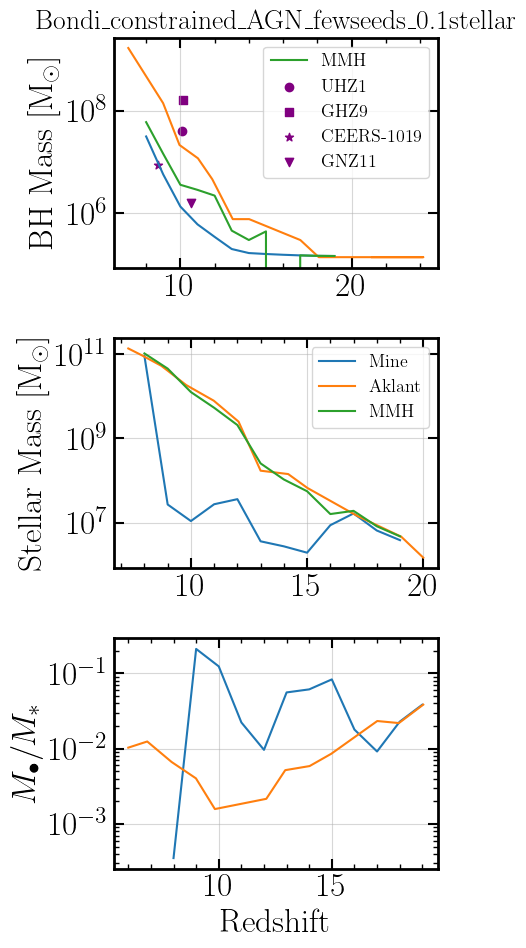

In [7]:
# seed_mass = 1.25e-6 *1e10/h # 1.5625e-07 #  1e-05  # 8.0e-8*1e10/h # 
# merger_driven_growth = seed_mass*(np.array(Progs) - 1)

Aklant_P1 = np.array([21.1965811965812, 140652.7242105239,24.188034188034187, 140652.7242105239,18.085470085470085, 140652.7242105239,17.00854700854701, 303027.1082866399,14.017094017094017, 774263.6826811278,13.05982905982906, 774263.6826811278,11.863247863247864, 4641588.833612773,11.025641025641027, 11859710.123376682,9.948717948717947, 21544346.90031878,8.991452991452991, 140652724.21052334,6.957264957264957, 1668100537.2000558,5.88034188034188, 1816599788.3753211])
Aklant_P2 = np.array([20, 1487018.543028375,19.05084745762712, 4671878.346444249,17.152542372881356, 14582829.828531083,15.016949152542376, 66704102.0756449,14.186440677966102, 142894043.03109777,13, 171718222.43883333,12.05084745762712, 2504137616.2833543,10.983050847457628, 7861043979.437935,9.796610169491526, 18490521181.76665,8.728813559322035, 52735676282.23356,7.898305084745763, 93246549121.75728,7.305084745762711, 136311939861.1788,6.11864406779661, 198458402666.89465])
Aklant_P3 = np.array([6, 0.01031823565045404,6.837606837606838, 0.012451970847350318,7.914529914529915, 0.0066547117963339205,8.991452991452991, 0.004031272694269965,9.82905982905983, 0.0015749940286401108,12.102564102564104, 0.0021544346900318778,12.94017094017094, 0.005179474679231202,14.017094017094017, 0.0058709378506924025,14.974358974358974, 0.00855013140036031,17.00854700854701, 0.023299518105153624,17.96581196581197, 0.02188447106460028,19.042735042735046, 0.038462190415362196,20, 0.10481131341546832])

Aklant_P1_x = Aklant_P1[list(np.arange(0,len(Aklant_P1)-2,2))]
Aklant_P1_y = Aklant_P1[list(np.arange(1,len(Aklant_P1)-1,2))]
Aklant_P2_x = Aklant_P2[list(np.arange(0,len(Aklant_P2)-2,2))]
Aklant_P2_y = Aklant_P2[list(np.arange(1,len(Aklant_P2)-1,2))]
Aklant_P3_x = Aklant_P3[list(np.arange(0,len(Aklant_P3)-2,2))]
Aklant_P3_y = Aklant_P3[list(np.arange(1,len(Aklant_P3)-1,2))]

fig,axs = plt.subplots(3,1,figsize=(5,10))
axs[0].plot(redshifts,Masses)
axs[1].plot(redshifts,Mstars,label = 'Mine')
axs[2].plot(redshifts,np.array(Masses)/np.array(Mstars),label = 'Mine')
axs[0].plot(Aklant_P1_x,Aklant_P1_y)
axs[1].plot(Aklant_P2_x,Aklant_P2_y,label = 'Aklant')
axs[2].plot(Aklant_P3_x,Aklant_P3_y,label = 'Aklant')
axs[1].plot(redshifts,MMH_Mstar,label = 'MMH')
axs[0].plot(redshifts,MMH_BH,label = 'MMH')

# plt.plot(redshifts,np.array(Masses)-(np.array(QM_growth)+np.array(RM_growth)+seed_mass),label='Growth via mergers',lw=3,alpha=0.75, ls='--')
# plt.plot(redshifts,merger_driven_growth,label='Growth via mergers',ls='--')
# plt.plot(redshifts,QM_growth,label='QM growth')
# plt.plot(redshifts,RM_growth,label='RM growth')

axs[0].scatter(UHZ1[0],UHZ1[1],label = 'UHZ1',color='purple',marker = 'o')
axs[0].scatter(GHZ9[0],GHZ9[1],label = 'GHZ9',color='purple',marker = 's')
axs[0].scatter(CEERS1019[0],CEERS1019[1],label = 'CEERS-1019',color='purple',marker = '*')
axs[0].scatter(GNZ11[0],GNZ11[1],label = 'GNZ11',color='purple',marker = 'v')

# plt.legend(fontsize=9)
for ax in axs:
    ax.set_yscale('log')
    ax.grid(alpha=0.5)

axs[0].set_ylabel(r'BH Mass [$\rm M_\odot$]')
axs[1].set_ylabel(r'Stellar Mass [$\rm M_\odot$]')
axs[2].set_ylabel(r'$M_{\bullet}/M_*$')
axs[2].set_xlabel('Redshift')
axs[0].set_title(f'{Simpath}',fontsize=20)
axs[0].legend(fontsize=13)
axs[1].legend(fontsize=13)
# plt.ylim(1e-1,1e9)

fig.tight_layout()
# plt.savefig(f'{Filepath}/{Simpath}/Plots/{Simpath}_BH_growth.png')
fig.savefig(f'Plots/{Simpath}_BH_Mstar_growth.png')

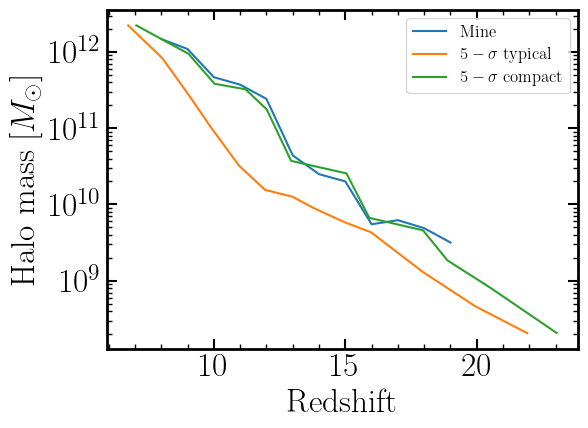

In [17]:
Aklant_typical = np.array([21.920353982300885, 205229177.69213182,19.93805309734513, 462792744.8995533,17.955752212389378, 1296801790.887413,15.97345132743363, 4323469099.22418,14.982300884955752, 5824199818.697809,13.805309734513273, 8927770731.391607,13, 12575225422.547234,11.946902654867255, 15524472924.479118,10.955752212389378, 32292377197.028774,9.84070796460177, 108242145856.8914,9.09734513274336, 256892373041.77594,8.044247787610619, 824796169802.0242,6.7433628318584065, 2222298899488.14,6, 4063962961586.129])
Aklant_typical_x = Aklant_typical[list(np.arange(0,len(Aklant_typical)-2,2))]
Aklant_typical_y = Aklant_typical[list(np.arange(1,len(Aklant_typical)-1,2))]

Aklant_compact = np.array([23.035398230088493, 206654380.2969724,20.49557522123894, 816906432.7062243,18.884955752212388, 1846382135.7598605,17.955752212389378, 4571338833.258387,15.911504424778762, 6673361197.968091,15.044247787610619, 25521880639.546726,12.938053097345133, 37243194006.408035,12.008849557522122, 176924350769.10837,11.20353982300885, 323420770806.7597,10.02654867256637, 382003307392.84235,9.035398230088497, 945413879027.5586,7.053097345132744, 2226575033920.034,6.061946902654866, 3271727250840.0312])
Aklant_compact_x = Aklant_compact[list(np.arange(0,len(Aklant_compact)-2,2))]
Aklant_compact_y = Aklant_compact[list(np.arange(1,len(Aklant_compact)-1,2))]

plt.plot(redshifts,Mhalo,label = 'Mine')
plt.plot(Aklant_typical_x,Aklant_typical_y,label = r'$5-\sigma$ typical')
plt.plot(Aklant_compact_x,Aklant_compact_y,label = r'$5-\sigma$ compact')
plt.legend(fontsize=12)
plt.yscale('log')
plt.xlabel('Redshift')
plt.ylabel(r'Halo mass [$M_\odot$]')
plt.tight_layout()
plt.savefig(f'Plots/{Simpath}_Mhalo.png')

# New 4 column plot

In [11]:
with h5py.File("Constrained.hdf5", "r") as f:
    print(f.keys())   # top-level groups in the file
    print(f['AGN_NS'].keys())
    print(f['AGN_NS']['Bondi'].keys())
    # data = f["MyDataset"][:]

<KeysViewHDF5 ['AGN_NS', 'AGN_S', 'NAGN_NS', 'NAGN_S']>
<KeysViewHDF5 ['Bondi', 'FF', 'modFF']>
<KeysViewHDF5 ['Accretion_growth', 'Edd', 'Masses', 'Mdots', 'Progs']>


In [ ]:
fig, axs = plt.subplots(1,4,figsize = (14,8),sharey = True)

files = ['Constrained','Zooms','Low_mass_seeds']

h = 0.6774
redshifts = np.linspace(19, 6, 14) # redshifts = np.linspace(12, 6, 7)
line_styles = ['-','--',':']
Mseeds = [1e-05,1.25e-06,1.5625e-07]

for i in range(len(files)):

    with h5py.File(f"output/{files[i]}_25.hdf5", "r") as f:

        Bondi_AGN_NS_mass = f['AGN_NS']['Bondi']['Masses'][6:]
        Bondi_AGN_S_mass = f['AGN_S']['Bondi']['Masses'][6:]
        Bondi_NAGN_S_mass = f['NAGN_S']['Bondi']['Masses'][6:]
        Bondi_NAGN_NS_mass = f['NAGN_NS']['Bondi']['Masses'][6:]

        FF_AGN_NS_mass = f['AGN_NS']['FF']['Masses'][6:]
        FF_AGN_S_mass = f['AGN_S']['FF']['Masses'][6:]
        FF_NAGN_S_mass = f['NAGN_S']['FF']['Masses'][6:]
        FF_NAGN_NS_mass = f['NAGN_NS']['FF']['Masses'][6:]

        modFF_AGN_NS_mass = f['AGN_NS']['modFF']['Masses'][6:]
        modFF_AGN_S_mass = f['AGN_S']['modFF']['Masses'][6:]
        modFF_NAGN_S_mass = f['NAGN_S']['modFF']['Masses'][6:]
        modFF_NAGN_NS_mass = f['NAGN_NS']['modFF']['Masses'][6:]

    if i == 0:
        axs[0].plot(redshifts,Bondi_AGN_S_mass,color = 'Blue',ls = line_styles[i],label = f'Bondi',lw=3)
        axs[0].plot(redshifts,FF_AGN_S_mass,color = 'orange',ls = line_styles[i],label = f'FF',lw=3)
        axs[0].plot(redshifts,modFF_AGN_S_mass,color = 'green',ls = line_styles[i],label = f'modFF',lw=3)
    else: 
        axs[0].plot(redshifts,Bondi_AGN_S_mass,color = 'Blue',ls = line_styles[i],lw=3)
        axs[0].plot(redshifts,FF_AGN_S_mass,color = 'orange',ls = line_styles[i],lw=3)
        axs[0].plot(redshifts,modFF_AGN_S_mass,color = 'green',ls = line_styles[i],lw=3)

    # Skipping parts of the sim that didn't get to z=6
    if i == 0:
        axs[1].plot(redshifts[:-2],Bondi_AGN_NS_mass[:-2],color = 'Blue',ls = line_styles[i],lw=3)
    else:
        axs[1].plot(redshifts,Bondi_AGN_NS_mass,color = 'Blue',ls = line_styles[i],lw=3)
        
    axs[2].plot(redshifts,Bondi_NAGN_S_mass,color = 'Blue',ls = line_styles[i],lw=3)
    axs[3].plot(redshifts,Bondi_NAGN_NS_mass,color = 'Blue',ls = line_styles[i],lw=3)

    axs[1].plot(redshifts,FF_AGN_NS_mass,color = 'orange',ls = line_styles[i],lw=3)
    axs[2].plot(redshifts,FF_NAGN_S_mass,color = 'orange',ls = line_styles[i],lw=3)
    axs[3].plot(redshifts,FF_NAGN_NS_mass,color = 'orange',ls = line_styles[i],lw=3)

    axs[1].plot(redshifts,modFF_AGN_NS_mass,color = 'green',ls = line_styles[i],lw=3)
    axs[2].plot(redshifts,modFF_NAGN_S_mass,color = 'green',ls = line_styles[i],lw=3)
    axs[3].plot(redshifts,modFF_NAGN_NS_mass,color = 'green',ls = line_styles[i],lw=3)

axs[0].set_title('AGN, Stellar',fontsize=25,y = 1.01)
axs[1].set_title('AGN, low Stellar',fontsize=25,y = 1.01)
axs[2].set_title('No AGN, Stellar',fontsize=25,y = 1.01)
axs[3].set_title('No AGN, low Stellar',fontsize=25,y = 1.01)

# Adding legend for different boxes
# axs[1].plot(0,0,ls = '-',color='k',label = r'$\rm M_{seed} = 10^5 M_\odot$',lw=3)
# axs[1].plot(0,0,ls = '--',color='k',label = r'$\rm M_{seed} = 10^4 M_\odot$',lw=3)
# axs[1].plot(0,0,ls = ':',color='k',label = r'$\rm M_{seed} = 10^3 M_\odot$',lw=3)

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('Redshift')
    ax.set_xlim(redshifts[-1],redshifts[0])
    ax.set_ylim(1e3,1e10)

    if ax == axs[0]:
        ax.hlines(Mseeds[0]*1e10/h,redshifts[-1],redshifts[0],alpha=0.5,ls = '-',color='k',lw=3)
        ax.hlines(Mseeds[1]*1e10/h,redshifts[-1],redshifts[0],alpha=0.5,ls = '--',color='k',lw=3)
        ax.hlines(Mseeds[2]*1e10/h,redshifts[-1],redshifts[0],alpha=0.5,ls = ':',color='k',lw=3)
    else:
        ax.hlines(Mseeds[0]*1e10/h,redshifts[-1],redshifts[0],alpha=0.5,ls = '-',color='k',label = r'$\rm M_{seed} \sim 10^5 M_\odot$',lw=3)
        ax.hlines(Mseeds[1]*1e10/h,redshifts[-1],redshifts[0],alpha=0.5,ls = '--',color='k',label = r'$\rm M_{seed} \sim 10^4 M_\odot$',lw=3)
        ax.hlines(Mseeds[2]*1e10/h,redshifts[-1],redshifts[0],alpha=0.5,ls = ':',color='k',label = r'$\rm M_{seed} \sim 10^3 M_\odot$',lw=3)

axs[0].set_ylabel(r'BH Mass [$M_\odot$]')
axs[0].legend(fontsize=17.5)
axs[1].legend(fontsize=17.5)

fig.tight_layout()
plt.subplots_adjust(wspace=0)
fig.savefig('Plots/Four_column_comparison_z20_wide.png')

# Plotting ratios of masses and accretion rates

In [39]:
files = ['Constrained','Zooms','Low_mass_seeds']
sim=2
file = files[sim]
redshifts = np.linspace(25, 6, 20)[10:]

with h5py.File(f"output/{file}_25.hdf5", "r") as f:

    # print(f['AGN_NS']['Bondi'].keys())

    Bondi_AGN_NS_mass = f['AGN_NS']['Bondi']['Masses'][10:]
    Bondi_AGN_S_mass = f['AGN_S']['Bondi']['Masses'][10:]
    Bondi_NAGN_S_mass = f['NAGN_S']['Bondi']['Masses'][10:]
    Bondi_NAGN_NS_mass = f['NAGN_NS']['Bondi']['Masses'][10:]

    FF_AGN_NS_mass = f['AGN_NS']['FF']['Masses'][10:]
    FF_AGN_S_mass = f['AGN_S']['FF']['Masses'][10:]
    FF_NAGN_S_mass = f['NAGN_S']['FF']['Masses'][10:]
    FF_NAGN_NS_mass = f['NAGN_NS']['FF']['Masses'][10:]

    modFF_AGN_NS_mass = f['AGN_NS']['modFF']['Masses'][10:]
    modFF_AGN_S_mass = f['AGN_S']['modFF']['Masses'][10:]
    modFF_NAGN_S_mass = f['NAGN_S']['modFF']['Masses'][10:]
    modFF_NAGN_NS_mass = f['NAGN_NS']['modFF']['Masses'][10:]

    Bondi_AGN_NS_mdots = f['AGN_NS']['Bondi']['Mdots'][10:]
    Bondi_AGN_S_mdots = f['AGN_S']['Bondi']['Mdots'][10:]
    Bondi_NAGN_S_mdots = f['NAGN_S']['Bondi']['Mdots'][10:]
    Bondi_NAGN_NS_mdots = f['NAGN_NS']['Bondi']['Mdots'][10:]

    FF_AGN_NS_mdots = f['AGN_NS']['FF']['Mdots'][10:]
    FF_AGN_S_mdots = f['AGN_S']['FF']['Mdots'][10:]
    FF_NAGN_S_mdots = f['NAGN_S']['FF']['Mdots'][10:]
    FF_NAGN_NS_mdots = f['NAGN_NS']['FF']['Mdots'][10:]

    modFF_AGN_NS_mdots = f['AGN_NS']['modFF']['Mdots'][10:]
    modFF_AGN_S_mdots = f['AGN_S']['modFF']['Mdots'][10:]
    modFF_NAGN_S_mdots = f['NAGN_S']['modFF']['Mdots'][10:]
    modFF_NAGN_NS_mdots = f['NAGN_NS']['modFF']['Mdots'][10:]

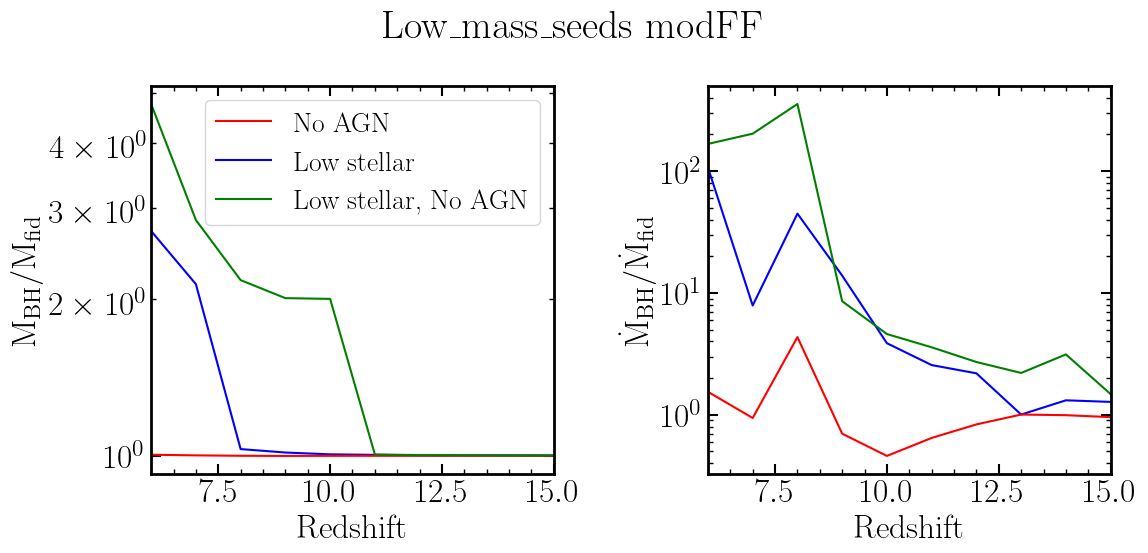

In [42]:
fig,axs = plt.subplots(1,2,figsize = (12,6))

model = 'modFF'

if model == 'Bondi':

    axs[0].plot(redshifts,Bondi_AGN_NS_mass/Bondi_AGN_S_mass,color = 'blue')
    axs[0].plot(redshifts,Bondi_NAGN_S_mass/Bondi_AGN_S_mass,color = 'red')
    axs[0].plot(redshifts,Bondi_NAGN_NS_mass/Bondi_AGN_S_mass,color = 'green')
    axs[0].set_ylabel(r'$\rm M_{BH}/M_{fid}$')
    
    axs[1].plot(redshifts,Bondi_AGN_NS_mdots/Bondi_AGN_S_mdots,color = 'blue')
    axs[1].plot(redshifts,Bondi_NAGN_S_mdots/Bondi_AGN_S_mdots,color = 'red')
    axs[1].plot(redshifts,Bondi_NAGN_NS_mdots/Bondi_AGN_S_mdots,color = 'green')
    axs[1].set_ylabel(r'$\rm \dot{M}_{BH}/\dot{M}_{fid}$')

elif model == 'FF':

    axs[0].plot(redshifts,FF_AGN_NS_mass/FF_AGN_S_mass,color = 'blue')
    axs[0].plot(redshifts,FF_NAGN_S_mass/FF_AGN_S_mass,color = 'red')
    axs[0].plot(redshifts,FF_NAGN_NS_mass/FF_AGN_S_mass,color = 'green')
    axs[0].set_ylabel(r'$\rm M_{BH}/M_{fid}$')
    
    axs[1].plot(redshifts,FF_AGN_NS_mdots/FF_AGN_S_mdots,color = 'blue')
    axs[1].plot(redshifts,FF_NAGN_S_mdots/FF_AGN_S_mdots,color = 'red')
    axs[1].plot(redshifts,FF_NAGN_NS_mdots/FF_AGN_S_mdots,color = 'green')
    axs[1].set_ylabel(r'$\rm \dot{M}_{BH}/\dot{M}_{fid}$')

elif model == 'modFF':

    axs[0].plot(redshifts,modFF_AGN_NS_mass/modFF_AGN_S_mass,color = 'blue')
    axs[0].plot(redshifts,modFF_NAGN_S_mass/modFF_AGN_S_mass,color = 'red')
    axs[0].plot(redshifts,modFF_NAGN_NS_mass/modFF_AGN_S_mass,color = 'green')
    axs[0].set_ylabel(r'$\rm M_{BH}/M_{fid}$')
    
    axs[1].plot(redshifts,modFF_AGN_NS_mdots/modFF_AGN_S_mdots,color = 'blue')
    axs[1].plot(redshifts,modFF_NAGN_S_mdots/modFF_AGN_S_mdots,color = 'red')
    axs[1].plot(redshifts,modFF_NAGN_NS_mdots/modFF_AGN_S_mdots,color = 'green')
    axs[1].set_ylabel(r'$\rm \dot{M}_{BH}/\dot{M}_{fid}$')

axs[0].plot(0,0,color = 'red',label = 'No AGN')
axs[0].plot(0,0,color = 'blue',label = 'Low stellar')
axs[0].plot(0,0,color = 'green',label = 'Low stellar, No AGN')
axs[0].legend(fontsize=20)

for ax in axs:
    ax.set_xlim(6,15)
    ax.set_yscale('log')
    ax.set_xlabel('Redshift')

fig.suptitle(f'{file}' + f' {model}',y=0.95)
fig.tight_layout()
fig.savefig(f'Plots/Ratios/{file}_{model}.png')